## librerias


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy import signal, stats
from pathlib import Path
from IPython.display import Audio, display
import warnings
from tqdm import tqdm

from collections import defaultdict
from matplotlib.patches import Patch
from scipy import signal

# Librerías TDA
from ripser import ripser
import persim

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneGroupOut, GroupKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

np.random.seed(42)




DATA_DIR = Path("data")
SLOW_DIR = DATA_DIR / "slow"
FAST_DIR = DATA_DIR / "fast"
OUTPUT_DIR = Path("preprocessed")
PREPROCESSED_DIR = OUTPUT_DIR
GRAPHS_DIR = Path("data/graphs")
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

GOOD_ELECTRODES_MATLAB = [
    2,
    3,
    4,
    6,
    7,
    9,
    11,
    12,
    13,
    14,
    15,
    16,
    18,
    19,
    20,
    21,
    22,
    24,
    25,
    26,
    27,
    28,
    30,
    31,
    33,
    34,
    36,
    38,
    40,
    41,
    42,
    44,
    45,
    46,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    56,
    57,
    58,
    59,
    60,
    65,
]
GOOD_ELECTRODES = [x - 1 for x in GOOD_ELECTRODES_MATLAB]
N_ELECTRODES = len(GOOD_ELECTRODES)
FREQ_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 50),
}


FILTER_ORDER = 4  # Butterworth filter order

WINDOW_SIZE_SEC = 1.0  # 1 second windows
OVERLAP_PERCENT = 0.75  # 75% overlap


print(f"Electrodos buenos: {N_ELECTRODES}")

slow_files = sorted(list(SLOW_DIR.glob("*.mat")))
fast_files = sorted(list(FAST_DIR.glob("*.mat")))

print(f"Archivos audio lento: {len(slow_files)}")
print(f"Archivos audio rápido: {len(fast_files)}")
print(f"Total: {len(slow_files) + len(fast_files)}")

print(f"  Frequency bands: {list(FREQ_BANDS.keys())}")
print(f"  Filter order: {FILTER_ORDER}")
print(f"  Window size: {WINDOW_SIZE_SEC} seconds")
print(f"  Window overlap: {OVERLAP_PERCENT * 100}%")




Electrodos buenos: 47
Archivos audio lento: 710
Archivos audio rápido: 706
Total: 1416
  Frequency bands: ['delta', 'theta', 'alpha', 'beta', 'gamma']
  Filter order: 4
  Window size: 1.0 seconds
  Window overlap: 75.0%


pip install scikit-learn

pip install ripser persim networkx


# eda


ARCHIVO LENTO:
  Fs: shape (1, 1)
  subeeg: shape (4606, 65)
  y: shape (812543, 2)

ARCHIVO RÁPIDO:
  Fs: shape (1, 1)
  subeeg: shape (2879, 65)
  y: shape (507839, 2)


EEG forma  Audio forma  Fs audio (Hz)  Duración (s)  Fs EEG (Hz)
Condición                                                                   
Lenta      (4606, 65)  (812543, 2)          44100         18.43       249.99
Rápida     (2879, 65)  (507839, 2)          44100         11.52       250.01

eeg_slow.shape = (4606, 65)
Esperado: (65, n_muestras) donde n_muestras >> 65
Transponiendo datos...
Nueva forma: (65, 4606)
EEG original: (65, 4606)
EEG buenos electrodos: (47, 4606)
Removidos: 18 electrodos

EEG Lento:
  NaN: 0
  Min: -130.090424, Max: 126.534592
  Media: -0.000000, Std: 28.551680

EEG Rápido:
  NaN: 0
  Min: -134.882385, Max: 112.794121
  Media: 0.000000, Std: 27.814211

Audio Lento:
  NaN: 0
  Min: -0.953674, Max: 0.854736
  Media: 0.000000, Std: 0.096133

Audio Rápido:
  NaN: 0
  Min: -0.897186, Max: 0.793427
  Media: 0.000005, Std: 0.082441


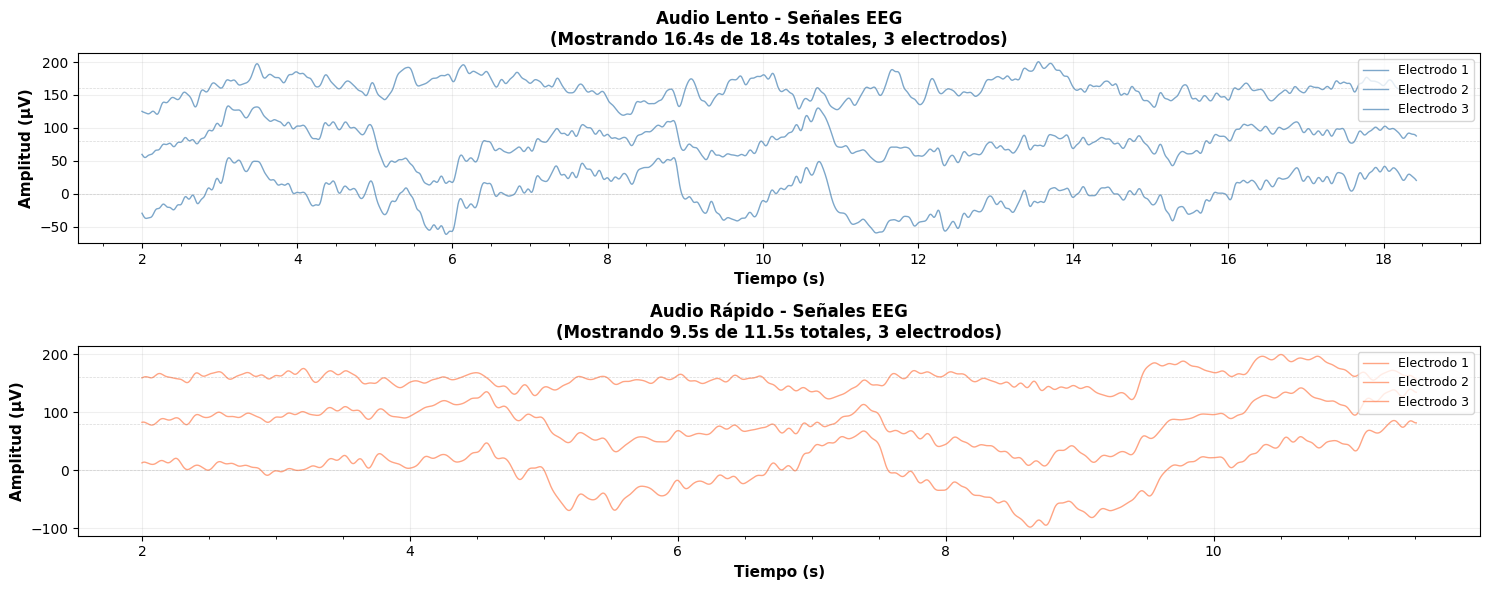

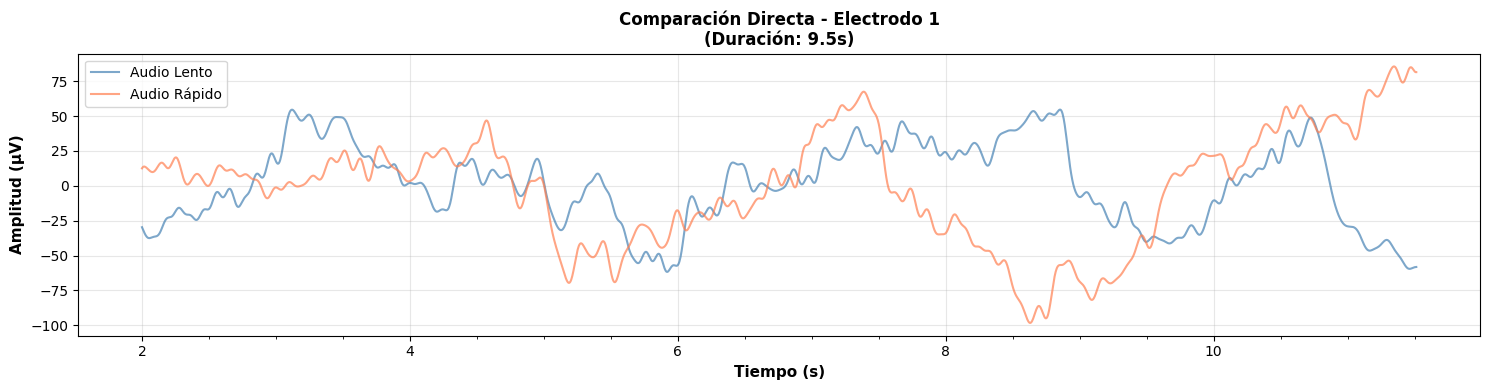

In [2]:


sample_slow_file = slow_files[0]
sample_fast_file = fast_files[0]

data_slow = loadmat(sample_slow_file)
data_fast = loadmat(sample_fast_file)

print("ARCHIVO LENTO:")
for key in data_slow.keys():
    if not key.startswith("__"):
        print(f"  {key}: shape {data_slow[key].shape}")

print("\nARCHIVO RÁPIDO:")
for key in data_fast.keys():
    if not key.startswith("__"):
        print(f"  {key}: shape {data_fast[key].shape}")
        

def resumen_archivo(data):
    eeg = data["subeeg"]
    audio = data["y"]
    fs_audio = int(data["Fs"][0, 0])
    dur_audio = audio.shape[0] / fs_audio
    fs_eeg = eeg.shape[0] / dur_audio
    return {
        "EEG forma": eeg.shape,
        "Audio forma": audio.shape,
        "Fs audio (Hz)": fs_audio,
        "Duración (s)": dur_audio,
        "Fs EEG (Hz)": fs_eeg,
    }, eeg, audio, fs_audio, fs_eeg

res_slow, eeg_slow, audio_slow, fs_audio, fs_eeg = resumen_archivo(data_slow)
res_fast, eeg_fast, audio_fast, fs_audio_fast, fs_eeg_fast = resumen_archivo(data_fast)

Fs_audio = fs_audio
Fs_eeg = int(round(fs_eeg))

resumen_df = pd.DataFrame([
    {"Condición": "Lenta", **res_slow},
    {"Condición": "Rápida", **res_fast},
]).set_index("Condición").round(2)

display(resumen_df)

print(f"eeg_slow.shape = {eeg_slow.shape}")
print(f"Esperado: (65, n_muestras) donde n_muestras >> 65")

if eeg_slow.shape[0] > eeg_slow.shape[1]:
    print("Transponiendo datos...")
    eeg_slow = eeg_slow.T
    eeg_fast = eeg_fast.T
    print(f"Nueva forma: {eeg_slow.shape}")
else:
    print("Orientación correcta")

eeg_slow_good = eeg_slow[GOOD_ELECTRODES, :]
eeg_fast_good = eeg_fast[GOOD_ELECTRODES, :]

print(f"EEG original: {eeg_slow.shape}")
print(f"EEG buenos electrodos: {eeg_slow_good.shape}")
print(f"Removidos: {eeg_slow.shape[0] - eeg_slow_good.shape[0]} electrodos")

def check_calidad(data, nombre):
    print(f"\n{nombre}:")
    print(f"  NaN: {np.isnan(data).sum()}")
    print(f"  Min: {np.min(data):.6f}, Max: {np.max(data):.6f}")
    print(f"  Media: {np.mean(data):.6f}, Std: {np.std(data):.6f}")

check_calidad(eeg_slow_good, "EEG Lento")
check_calidad(eeg_fast_good, "EEG Rápido")
check_calidad(audio_slow, "Audio Lento")
check_calidad(audio_fast, "Audio Rápido")

# Visualización de señales EEG - Mostrar grabación completa o porción específica
duration_plot = None  # None = grabación completa, o especificar segundos (ej: 14)
n_channels_plot = 3  # Número de electrodos a mostrar
skip_samples = 500  # Saltar primeras muestras (pueden contener artefactos)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

def plot_eeg(ax, data, titulo, fs, color='blue', duration=None, skip=0):
    """
    Graficar señales EEG con eje de tiempo correcto.
    
    Parámetros:
    -----------
    ax : matplotlib axis
    data : ndarray, shape (n_channels, n_samples)
    titulo : str
    fs : int, frecuencia de muestreo
    color : str
    duration : float or None, duración en segundos (None = todo)
    skip : int, muestras a saltar al inicio
    """
    # Calcular muestras disponibles
    available_samples = data.shape[1] - skip
    
    # Determinar cuántas muestras plotear
    if duration is None:
        # Usar toda la grabación
        samples = available_samples
    else:
        # Usar duración especificada
        samples = min(int(duration * fs), available_samples)
    
    # Crear eje de tiempo que empieza desde skip/fs
    time = (np.arange(samples) + skip) / fs
    
    # Graficar cada canal con offset
    for i in range(min(n_channels_plot, data.shape[0])):
        offset = i * 80
        ax.plot(time, data[i, skip:skip + samples] + offset, 
                label=f"Electrodo {i + 1}", 
                color=color, alpha=0.7, linewidth=1)
        ax.axhline(y=offset, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
    
    # Calcular duración real mostrada
    duration_shown = samples / fs
    total_duration = data.shape[1] / fs
    
    ax.set_title(f"{titulo}\n(Mostrando {duration_shown:.1f}s de {total_duration:.1f}s totales, {min(n_channels_plot, data.shape[0])} electrodos)", 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Tiempo (s)", fontsize=11, fontweight='bold')
    ax.set_ylabel("Amplitud (μV)", fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.2)
    
    # Configurar ticks del eje X para mostrar tiempo claramente
    if duration_shown > 60:
        # Si es más de 1 minuto, mostrar cada 10 segundos
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
    elif duration_shown > 20:
        # Si es más de 20 segundos, mostrar cada 5 segundos
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    else:
        # Para duraciones cortas, mostrar cada 2 segundos
        ax.xaxis.set_major_locator(plt.MultipleLocator(2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    
    return ax

plot_eeg(axes[0], eeg_slow_good, "Audio Lento - Señales EEG", Fs_eeg, 
         'steelblue', duration=duration_plot, skip=skip_samples)
plot_eeg(axes[1], eeg_fast_good, "Audio Rápido - Señales EEG", Fs_eeg, 
         'coral', duration=duration_plot, skip=skip_samples)

plt.tight_layout()
plt.show()

# Comparación de un solo electrodo superpuesto
electrode_compare = 0
fig, ax = plt.subplots(figsize=(15, 4))

# Calcular muestras
available_slow = eeg_slow_good.shape[1] - skip_samples
available_fast = eeg_fast_good.shape[1] - skip_samples

if duration_plot is None:
    samples = min(available_slow, available_fast)
else:
    samples = min(int(duration_plot * Fs_eeg), available_slow, available_fast)

# Crear eje de tiempo
time = (np.arange(samples) + skip_samples) / Fs_eeg

ax.plot(time, eeg_slow_good[electrode_compare, skip_samples:skip_samples + samples], 
        label='Audio Lento', color='steelblue', alpha=0.7, linewidth=1.5)
ax.plot(time, eeg_fast_good[electrode_compare, skip_samples:skip_samples + samples], 
        label='Audio Rápido', color='coral', alpha=0.7, linewidth=1.5)

duration_shown = samples / Fs_eeg
ax.set_title(f"Comparación Directa - Electrodo {electrode_compare + 1}\n(Duración: {duration_shown:.1f}s)", 
             fontsize=12, fontweight='bold')
ax.set_xlabel("Tiempo (s)", fontsize=11, fontweight='bold')
ax.set_ylabel("Amplitud (μV)", fontsize=11, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Configurar ticks del eje X
if duration_shown > 60:
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
elif duration_shown > 20:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
else:
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))

plt.tight_layout()
plt.show()

Audio Lento (velocidad normal):



Audio Rápido (acelerado):


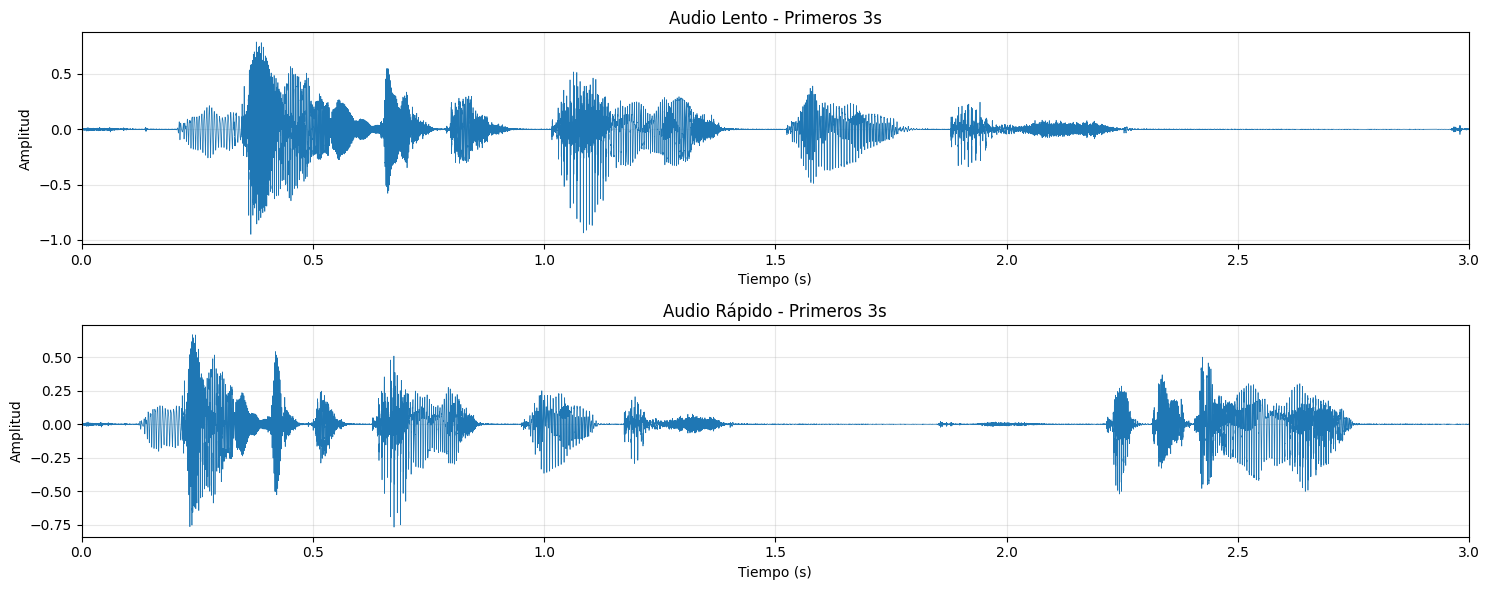


Duración total audio lento: 18.43 s
Duración total audio rápido: 11.52 s


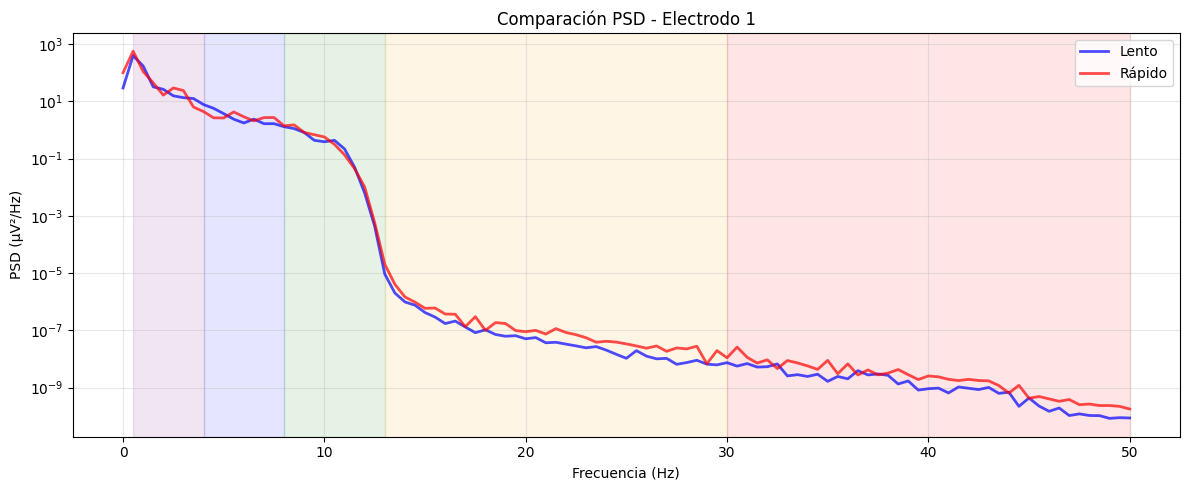

In [3]:


# Reproducir audio lento
print("Audio Lento (velocidad normal):")
display(Audio(audio_slow[:, 0], rate=Fs_audio))

print("\nAudio Rápido (acelerado):")
display(Audio(audio_fast[:, 0], rate=Fs_audio))

# Visualización de forma de onda (primeros 3 segundos)
duration_to_plot = 3
samples_slow = int(duration_to_plot * Fs_audio)
samples_fast = int(duration_to_plot * Fs_audio)

time_slow = np.arange(samples_slow) / Fs_audio
time_fast = np.arange(samples_fast) / Fs_audio

audio_slow_mono = audio_slow[:, 0] if audio_slow.ndim > 1 else audio_slow
audio_fast_mono = audio_fast[:, 0] if audio_fast.ndim > 1 else audio_fast

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].plot(time_slow, audio_slow_mono[:samples_slow], linewidth=0.5)
axes[0].set_title(f"Audio Lento - Primeros {duration_to_plot}s")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")
axes[0].set_xlim(0, duration_to_plot)
axes[0].grid(alpha=0.3)

axes[1].plot(time_fast, audio_fast_mono[:samples_fast], linewidth=0.5)
axes[1].set_title(f"Audio Rápido - Primeros {duration_to_plot}s")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")
axes[1].set_xlim(0, duration_to_plot)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDuración total audio lento: {len(audio_slow) / Fs_audio:.2f} s")
print(f"Duración total audio rápido: {len(audio_fast) / Fs_audio:.2f} s")



electrode_idx = 0
freqs_slow, psd_slow = signal.welch(
    eeg_slow_good[electrode_idx, :],
    fs=Fs_eeg,
    nperseg=min(2 * Fs_eeg, eeg_slow_good.shape[1])
)

freqs_fast, psd_fast = signal.welch(
    eeg_fast_good[electrode_idx, :],
    fs=Fs_eeg,
    nperseg=min(2 * Fs_eeg, eeg_fast_good.shape[1])
)

fig, ax = plt.subplots(figsize=(12, 5))
freq_mask = freqs_slow <= 50

# Bandas de frecuencia
bandas = [
    (0.5, 4, "purple", "Delta"),
    (4, 8, "blue", "Theta"),
    (8, 13, "green", "Alpha"),
    (13, 30, "orange", "Beta"),
    (30, 50, "red", "Gamma")
]

for inicio, fin, color, nombre in bandas:
    ax.axvspan(inicio, fin, alpha=0.1, color=color)

ax.semilogy(freqs_slow[freq_mask], psd_slow[freq_mask], 'b-', linewidth=2, label='Lento', alpha=0.7)
ax.semilogy(freqs_fast[freq_mask], psd_fast[freq_mask], 'r-', linewidth=2, label='Rápido', alpha=0.7)
ax.set_title(f"Comparación PSD - Electrodo {electrode_idx+1}")
ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("PSD (μV²/Hz)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

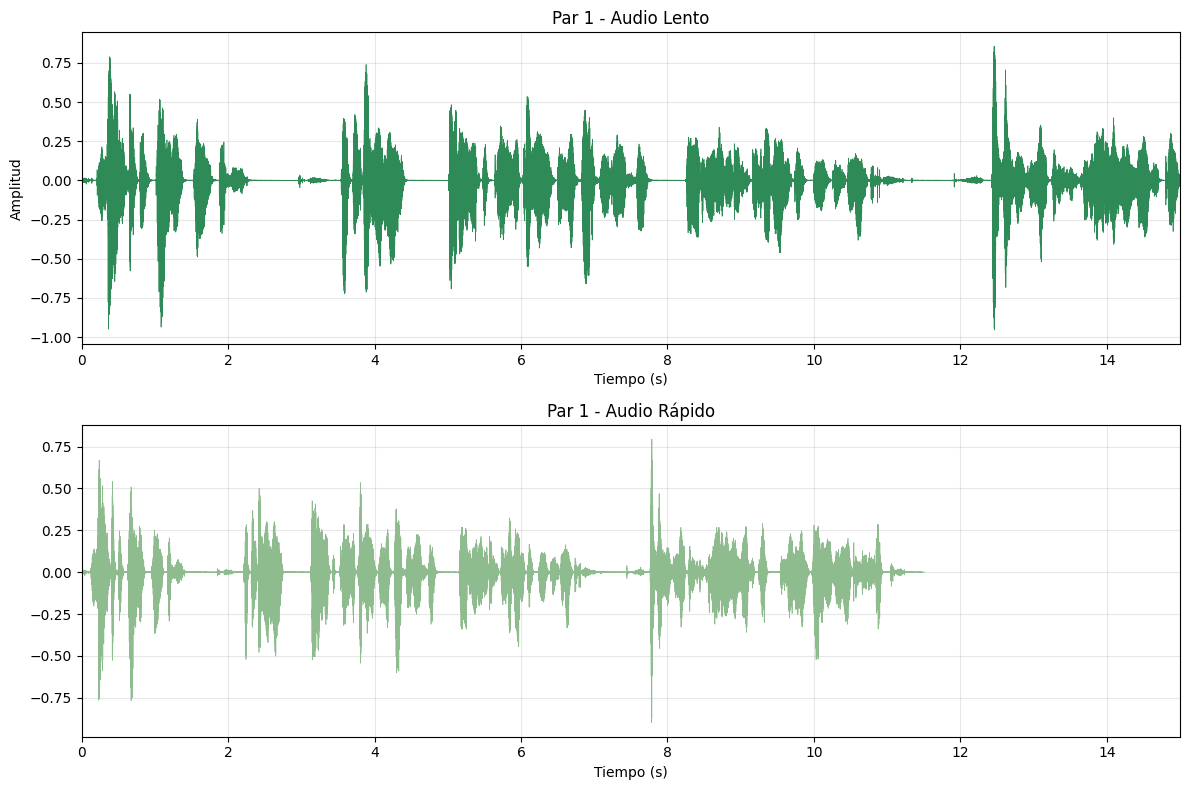

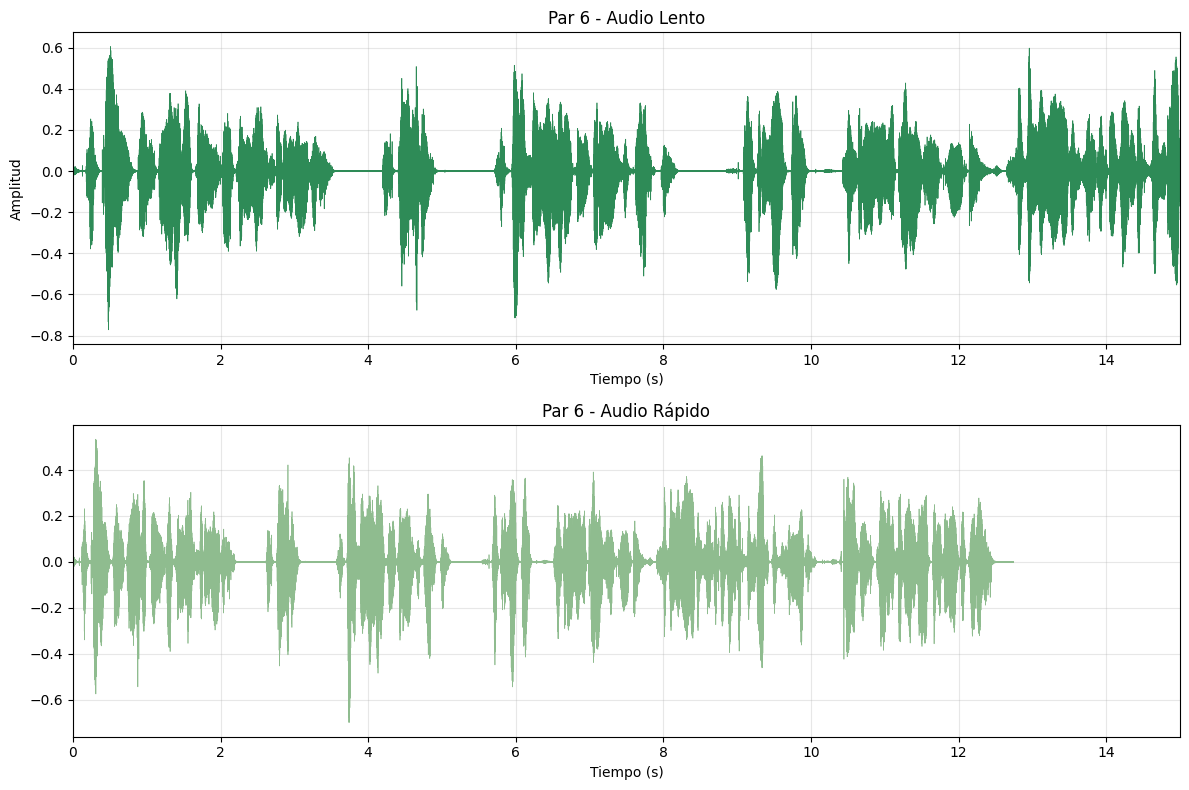

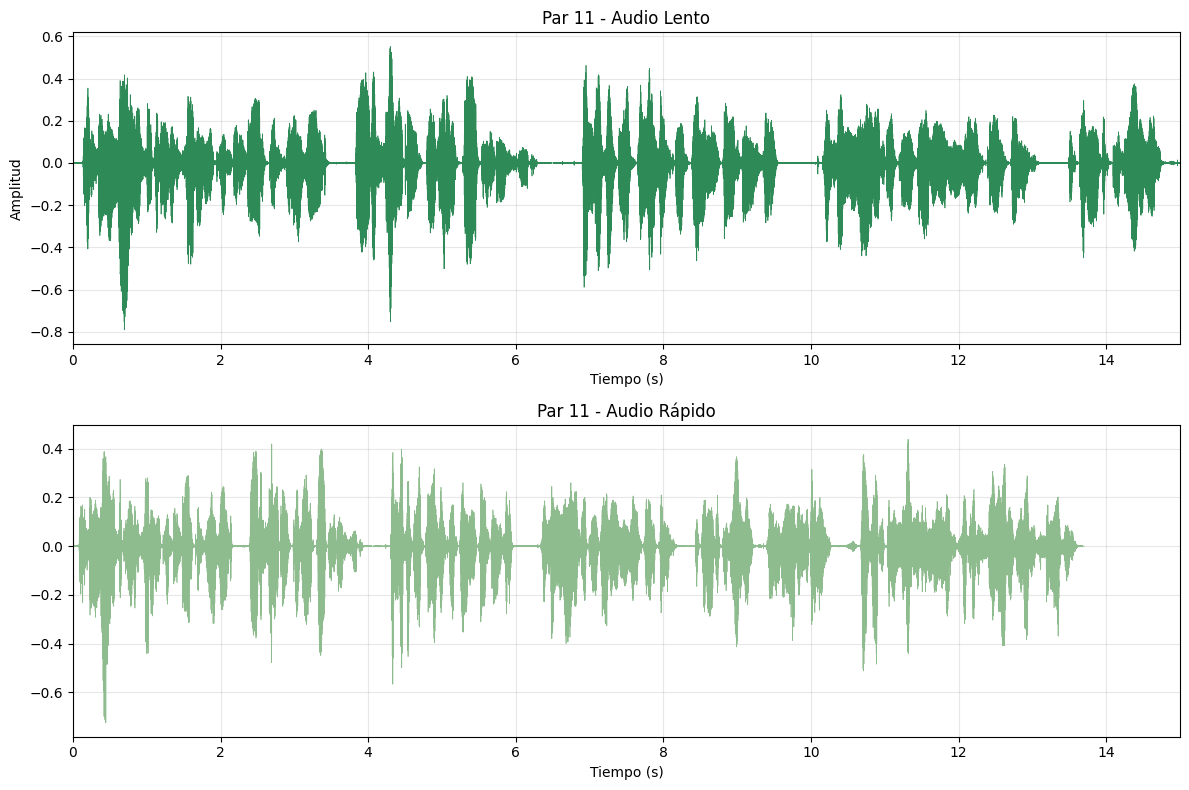

Cada figura muestra un par diferente de audio (slow-fast del mismo contenido)


In [4]:
n_pairs = 3
pair_indices = [0, 5, 10]

for idx, pair_idx in enumerate(pair_indices):
    # Cargar par slow-fast
    data_s = loadmat(slow_files[pair_idx])
    data_f = loadmat(fast_files[pair_idx])
    
    audio_s = data_s["y"][:, 0] if data_s["y"].ndim > 1 else data_s["y"]
    audio_f = data_f["y"][:, 0] if data_f["y"].ndim > 1 else data_f["y"]
   
    dur = 15  # Duración a graficar en segundos
    samples_s = min(int(dur * Fs_audio), len(audio_s))
    samples_f = min(int(dur * Fs_audio), len(audio_f))
    
    time_s = np.arange(samples_s) / Fs_audio
    time_f = np.arange(samples_f) / Fs_audio
    
    # Crear figura individual para cada par
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(time_s, audio_s[:samples_s], linewidth=0.5, color='seagreen')
    axes[0].set_title(f"Par {pair_idx+1} - Audio Lento")
    axes[0].set_ylabel("Amplitud")
    axes[0].set_xlabel("Tiempo (s)")
    axes[0].set_xlim(0, dur)
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(time_f, audio_f[:samples_f], linewidth=0.5, color='darkseagreen')
    axes[1].set_title(f"Par {pair_idx+1} - Audio Rápido")
    axes[1].set_xlabel("Tiempo (s)")
    axes[1].set_xlim(0, dur)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Cada figura muestra un par diferente de audio (slow-fast del mismo contenido)")

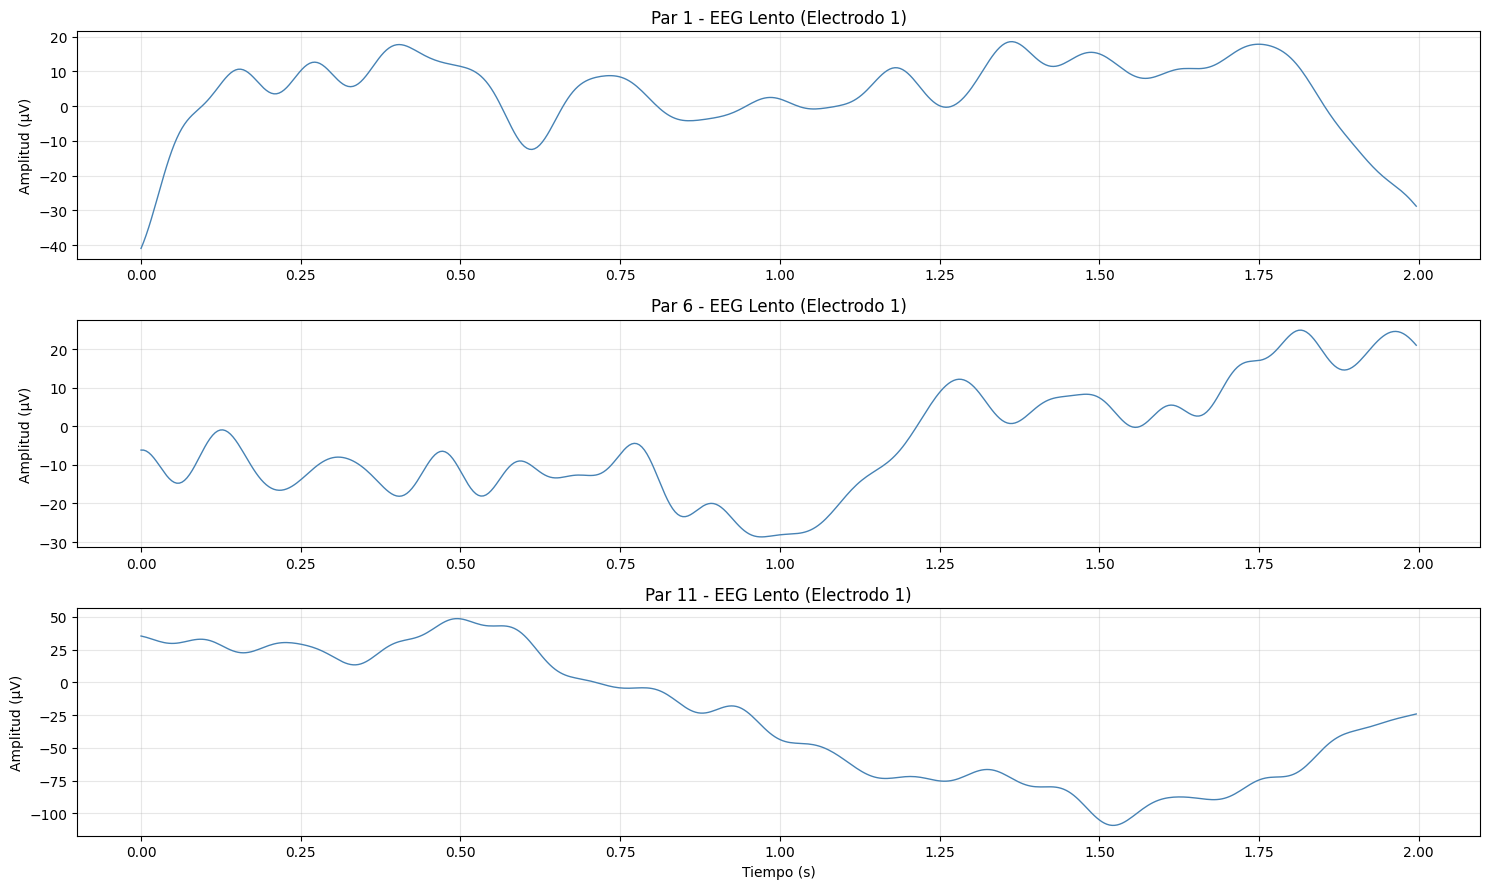

Cada gráfico muestra la señal EEG de un par diferente de audio (condición lenta)


In [5]:
# Comparar señales EEG de 3 pares diferentes (slow)
n_pairs_eeg = 3
pair_indices_eeg = [0, 5, 10]
electrode_to_plot = 0
dur_eeg = 2

fig, axes = plt.subplots(n_pairs_eeg, 1, figsize=(15, 3*n_pairs_eeg))

for idx, pair_idx in enumerate(pair_indices_eeg):
    # Cargar datos
    data_s = loadmat(slow_files[pair_idx])
    eeg_data = data_s["subeeg"]
    
    # Transponer si es necesario
    if eeg_data.shape[0] > eeg_data.shape[1]:
        eeg_data = eeg_data.T
    
    # Seleccionar buenos electrodos
    eeg_good = eeg_data[GOOD_ELECTRODES, :]
    
    # Graficar
    samples = min(int(dur_eeg * Fs_eeg), eeg_good.shape[1])
    time = np.arange(samples) / Fs_eeg
    
    axes[idx].plot(time, eeg_good[electrode_to_plot, :samples], linewidth=1, color='steelblue')
    axes[idx].set_title(f"Par {pair_idx+1} - EEG Lento (Electrodo {electrode_to_plot+1})")
    axes[idx].set_ylabel("Amplitud (μV)")
    axes[idx].grid(alpha=0.3)
    
    if idx == n_pairs_eeg - 1:
        axes[idx].set_xlabel("Tiempo (s)")

plt.tight_layout()
plt.show()

print("Cada gráfico muestra la señal EEG de un par diferente de audio (condición lenta)")

# parte filtro


In [6]:

# cargar datos funcion
def load_eeg_file(filepath):
    """
    Load EEG data from .mat file and extract good electrodes.

    Parameters:
    -----------
    filepath : Path or str
        Path to .mat file

    Returns:
    --------
    eeg : ndarray, shape (N_ELECTRODES, n_samples)
        EEG data from good electrodes only
    audio : ndarray, shape (n_samples,) or (n_samples, n_channels)
        Audio signal
    fs_eeg : int
        EEG sampling frequency (calculated)
    fs_audio : int
        Audio sampling frequency
    """
    data = loadmat(filepath)

    # Extract components
    eeg_all = data["subeeg"]
    audio = data["y"]
    fs_audio = int(data["Fs"][0, 0])

    # Check if EEG data needs transposing
    # EEG should be (n_samples, n_electrodes), we want (n_electrodes, n_samples)
    if eeg_all.shape[0] > eeg_all.shape[1]:
        eeg_all = eeg_all.T

    # Extract only good electrodes
    eeg = eeg_all[GOOD_ELECTRODES, :]

    # Calculate EEG sampling rate from audio duration
    audio_duration = audio.shape[0] / fs_audio
    fs_eeg = int(round(eeg.shape[1] / audio_duration))

    # Flatten audio if stereo
    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    return eeg, audio, fs_eeg, fs_audio


# Test the function
test_file = list(SLOW_DIR.glob("*.mat"))[0]
eeg_test, audio_test, fs_eeg_test, fs_audio_test = load_eeg_file(test_file)
print(f"✓ Test file loaded: {test_file.name}")
print(f"  EEG shape: {eeg_test.shape} (electrodes × samples)")
print(f"  Audio shape: {audio_test.shape}")
print(f"  EEG sampling frequency: {fs_eeg_test} Hz")
print(f"  Audio sampling frequency: {fs_audio_test} Hz")
print(f"  EEG duration: {eeg_test.shape[1] / fs_eeg_test:.2f} seconds")
print(f"  Audio duration: {audio_test.shape[0] / fs_audio_test:.2f} seconds")

# filtros
FS_EEG = fs_eeg_test
FS_AUDIO = fs_audio_test
print(f"usando {FS_EEG} Hz")


def design_bandpass_filter(lowcut, highcut, fs, order=4):
    """
    Design a Butterworth bandpass filter.

    Parameters:
    -----------
    lowcut : float
        Lower frequency bound (Hz)
    highcut : float
        Upper frequency bound (Hz)
    fs : int
        Sampling frequency (Hz)
    order : int
        Filter order

    Returns:
    --------
    sos : ndarray
        Second-order sections representation of the filter
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(order, [low, high], btype="band", output="sos")
    return sos


def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply bandpass filter to data.

    Parameters:
    -----------
    data : ndarray, shape (n_channels, n_samples)
        Input data
    lowcut : float
        Lower frequency bound (Hz)
    highcut : float
        Upper frequency bound (Hz)
    fs : int
        Sampling frequency (Hz)
    order : int
        Filter order

    Returns:
    --------
    filtered_data : ndarray, shape (n_channels, n_samples)
        Filtered data
    """
    sos = design_bandpass_filter(lowcut, highcut, fs, order)

    # Apply filter to each channel using zero-phase filtering
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_data[i, :] = signal.sosfiltfilt(sos, data[i, :])

    return filtered_data


# Test filtering on one band
print("Testing bandpass filter...")
lowcut, highcut = FREQ_BANDS["alpha"]
eeg_filtered = apply_bandpass_filter(eeg_test, lowcut, highcut, FS_EEG, FILTER_ORDER)
print(f"✓ Alpha band filter applied: {lowcut}-{highcut} Hz")
print(f"  EEG sampling rate used: {FS_EEG} Hz")
print(f"  Input shape: {eeg_test.shape}")
print(f"  Output shape: {eeg_filtered.shape}")

✓ Test file loaded: bb19_ut04.mat
  EEG shape: (47, 5516) (electrodes × samples)
  Audio shape: (972920,)
  EEG sampling frequency: 250 Hz
  Audio sampling frequency: 44100 Hz
  EEG duration: 22.06 seconds
  Audio duration: 22.06 seconds
usando 250 Hz
Testing bandpass filter...
✓ Alpha band filter applied: 8-13 Hz
  EEG sampling rate used: 250 Hz
  Input shape: (47, 5516)
  Output shape: (47, 5516)


#### revisar que la validacion este correcta, no cacho como se hacen los graficos y el filtro


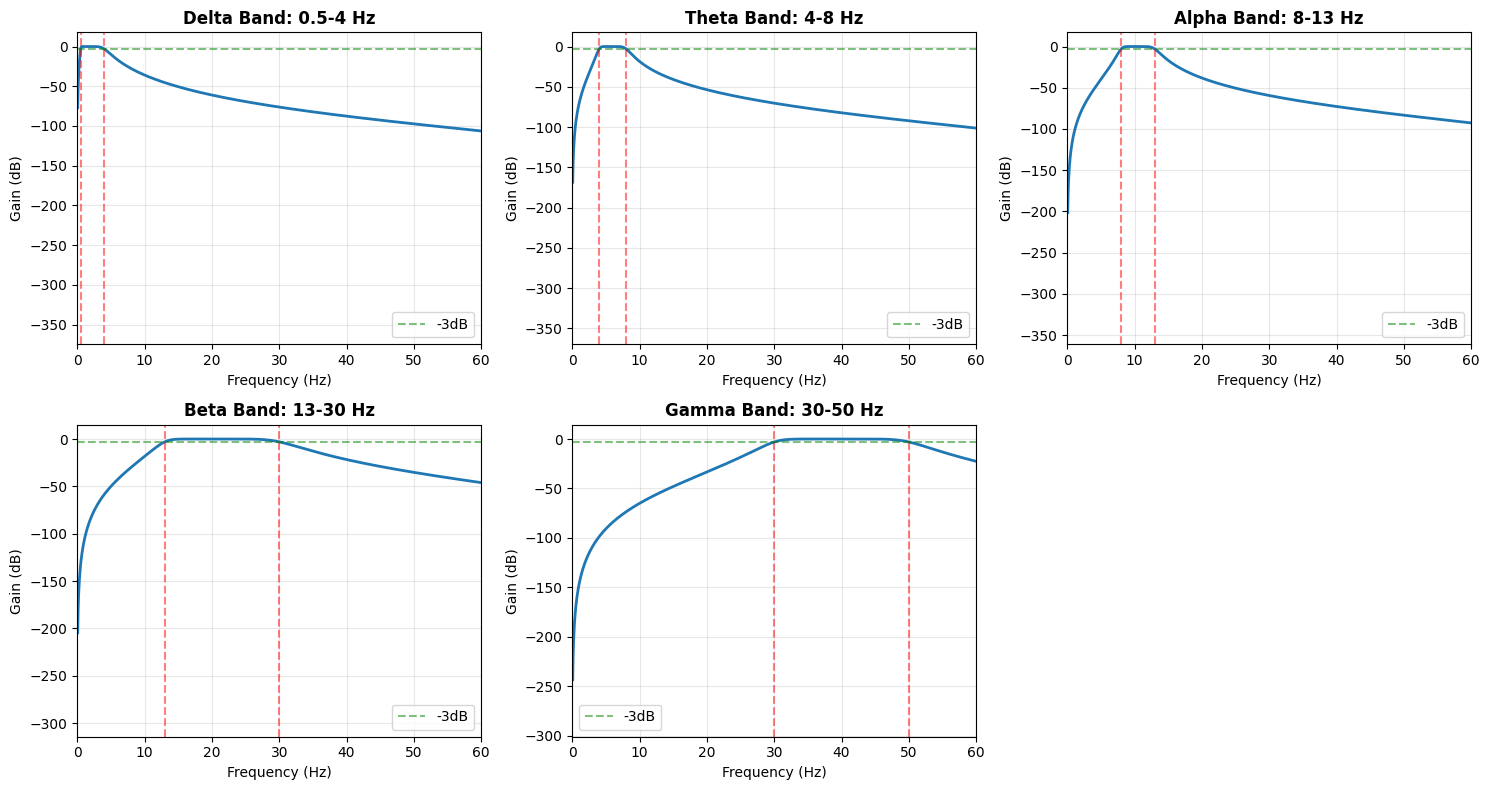

✓ Filter frequency responses validated (EEG Fs = 250 Hz)


In [7]:
# Plot frequency response of all filters
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (band_name, (lowcut, highcut)) in enumerate(FREQ_BANDS.items()):
    sos = design_bandpass_filter(lowcut, highcut, FS_EEG, FILTER_ORDER)
    w, h = signal.sosfreqz(sos, worN=2000, fs=FS_EEG)

    axes[idx].plot(w, 20 * np.log10(abs(h)), linewidth=2)
    axes[idx].set_title(
        f"{band_name.capitalize()} Band: {lowcut}-{highcut} Hz", fontweight="bold"
    )
    axes[idx].set_xlabel("Frequency (Hz)")
    axes[idx].set_ylabel("Gain (dB)")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 60])
    axes[idx].axvline(lowcut, color="r", linestyle="--", alpha=0.5)
    axes[idx].axvline(highcut, color="r", linestyle="--", alpha=0.5)
    axes[idx].axhline(-3, color="g", linestyle="--", alpha=0.5, label="-3dB")
    axes[idx].legend()

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()
print(f"✓ Filter frequency responses validated (EEG Fs = {FS_EEG} Hz)")


In [8]:


def create_sliding_windows(data, window_size, overlap, fs):
    """
    Create sliding windows from continuous data.

    Parameters:
    -----------
    data : ndarray, shape (n_channels, n_samples)
        Input data
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction (0-1)
    fs : int
        Sampling frequency

    Returns:
    --------
    windows : ndarray, shape (n_windows, n_channels, window_samples)
        Windowed data
    window_times : ndarray, shape (n_windows,)
        Center time of each window in seconds
    """
    n_channels, n_samples = data.shape
    window_samples = int(window_size * fs)
    step_samples = int(window_samples * (1 - overlap))

    # Calculate number of windows
    n_windows = (n_samples - window_samples) // step_samples + 1

    # Handle edge case where recording is too short
    if n_windows < 1:
        print(
            f"Warning: Recording too short for {window_size}s windows (only {n_samples / fs:.2f}s)"
        )
        return np.array([]), np.array([])

    # Preallocate array
    windows = np.zeros((n_windows, n_channels, window_samples))
    window_times = np.zeros(n_windows)

    # Extract windows
    for i in range(n_windows):
        start_idx = i * step_samples
        end_idx = start_idx + window_samples

        if end_idx <= n_samples:
            windows[i, :, :] = data[:, start_idx:end_idx]
            window_times[i] = (start_idx + window_samples // 2) / fs

    return windows, window_times


# Test sliding window function
windows_test, times_test = create_sliding_windows(
    eeg_filtered, WINDOW_SIZE_SEC, OVERLAP_PERCENT, FS_EEG
)

print(f"✓ Sliding windows created")
print(f"  Input shape: {eeg_filtered.shape}")
print(f"  Window shape: {windows_test.shape}")
print(f"  Number of windows: {windows_test.shape[0]}")
print(f"  Window size: {WINDOW_SIZE_SEC}s = {int(WINDOW_SIZE_SEC * FS_EEG)} samples")
print(f"  Step size: {int(WINDOW_SIZE_SEC * FS_EEG * (1 - OVERLAP_PERCENT))} samples")
if len(times_test) > 0:
    print(f"  Time range: {times_test[0]:.2f}s to {times_test[-1]:.2f}s")

✓ Sliding windows created
  Input shape: (47, 5516)
  Window shape: (85, 47, 250)
  Number of windows: 85
  Window size: 1.0s = 250 samples
  Step size: 62 samples
  Time range: 0.50s to 21.33s


In [10]:
# preprocesamiento 
def preprocess_file(
    filepath, output_dir, freq_bands, window_size, overlap, fs_eeg, filter_order=4
):
    """
    Complete preprocessing pipeline for a single file.

    Steps:
    1. Load EEG data (good electrodes only)
    2. Filter into frequency bands
    3. Create sliding windows for each band
    4. Save preprocessed data

    Parameters:
    -----------
    filepath : Path
        Path to input .mat file
    output_dir : Path
        Directory to save preprocessed data
    freq_bands : dict
        Dictionary of frequency bands {name: (low, high)}
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction (0-1)
    fs_eeg : int
        EEG sampling frequency
    filter_order : int
        Butterworth filter order

    Returns:
    --------
    metadata : dict
        Metadata about the processed file
    """
    # Load data
    eeg, audio, fs_eeg_file, fs_audio = load_eeg_file(filepath)

    # Verify sampling frequency matches expected
    if abs(fs_eeg_file - fs_eeg) > 1:  # Allow 1 Hz tolerance
        print(
            f"Warning: EEG sampling frequency mismatch in {filepath.name}: {fs_eeg_file} Hz vs expected {fs_eeg} Hz"
        )
        # Use the file's actual sampling rate
        fs_eeg = fs_eeg_file

    # Create output directory for this file
    file_output_dir = output_dir / filepath.stem
    file_output_dir.mkdir(parents=True, exist_ok=True)

    # Process each frequency band
    band_metadata = {}
    windows_shape = None
    window_times = None

    for band_name, (lowcut, highcut) in freq_bands.items():
        # Filter
        eeg_filtered = apply_bandpass_filter(eeg, lowcut, highcut, fs_eeg, filter_order)

        # Create windows
        windows, window_times = create_sliding_windows(
            eeg_filtered, window_size, overlap, fs_eeg
        )

        # Skip if no windows could be created
        if windows.shape[0] == 0:
            continue

        # Save windowed data
        output_file = file_output_dir / f"{band_name}.npy"
        np.save(output_file, windows)

        band_metadata[band_name] = {
            "n_windows": windows.shape[0],
            "window_shape": windows.shape,
            "freq_range": (lowcut, highcut),
        }

        windows_shape = windows.shape

    # If no windows were created, return None
    if windows_shape is None or windows_shape[0] == 0:
        return None

    # Save window times (same for all bands)
    np.save(file_output_dir / "window_times.npy", window_times)

    # Save audio (for future use)
    np.save(file_output_dir / "audio.npy", audio)

    # Metadata
    metadata = {
        "filename": filepath.name,
        "n_electrodes": eeg.shape[0],
        "n_samples": eeg.shape[1],
        "duration_sec": eeg.shape[1] / fs_eeg,
        "fs_eeg": fs_eeg,
        "bands": band_metadata,
        "n_windows": windows_shape[0],
    }

    return metadata


# Test on one file
print("Testing preprocessing pipeline on one file...")
test_output = OUTPUT_DIR / "slow"
metadata_test = preprocess_file(
    test_file,
    test_output,
    FREQ_BANDS,
    WINDOW_SIZE_SEC,
    OVERLAP_PERCENT,
    FS_EEG,
    FILTER_ORDER,
)

if metadata_test is not None:
    print("\n✓ Preprocessing test successful!")
    print(f"  File: {metadata_test['filename']}")
    print(f"  Duration: {metadata_test['duration_sec']:.2f}s")
    print(f"  EEG sampling rate: {metadata_test['fs_eeg']} Hz")
    print(f"  Number of windows: {metadata_test['n_windows']}")
    print(f"  Bands processed: {list(metadata_test['bands'].keys())}")
else:
    print("\n✗ Preprocessing test failed - file too short")


def batch_preprocess(
    input_dir, output_dir, freq_bands, window_size, overlap, fs_eeg, filter_order=4
):
    """
    Preprocess all files in a directory.

    Parameters:
    -----------
    input_dir : Path
        Directory containing .mat files
    output_dir : Path
        Directory to save preprocessed data
    freq_bands : dict
        Dictionary of frequency bands
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction
    fs_eeg : int
        EEG sampling frequency
    filter_order : int
        Filter order

    Returns:
    --------
    all_metadata : list
        List of metadata dictionaries for all processed files
    """
    files = sorted(list(input_dir.glob("*.mat")))
    all_metadata = []
    failed_files = []

    print(f"Processing {len(files)} files from {input_dir.name}...")

    for filepath in tqdm(files, desc="Preprocessing"):
        try:
            metadata = preprocess_file(
                filepath,
                output_dir,
                freq_bands,
                window_size,
                overlap,
                fs_eeg,
                filter_order,
            )
            if metadata is not None:
                all_metadata.append(metadata)
            else:
                failed_files.append(filepath.name)
        except Exception as e:
            print(f"\nError processing {filepath.name}: {str(e)}")
            failed_files.append(filepath.name)

    print(f"\n✓ Preprocessing complete!")
    print(f"  Successfully processed: {len(all_metadata)} files")
    print(f"  Failed: {len(failed_files)} files")

    if failed_files:
        print(f"  Failed files: {failed_files[:5]}...")

    return all_metadata, failed_files


# Check if preprocessing has already been done
slow_output = OUTPUT_DIR / "slow"
fast_output = OUTPUT_DIR / "fast"
preprocessing_done = (
    slow_output.exists() 
    and fast_output.exists() 
    and (OUTPUT_DIR / "preprocessing_metadata.csv").exists()
    and len(list(slow_output.glob("*"))) > 0
    and len(list(fast_output.glob("*"))) > 0
)

if preprocessing_done:
    print("=" * 60)
    print("PREPROCESSING ALREADY COMPLETED")
    print("=" * 60)
    print("Skipping preprocessing - data already exists.")
    print(f"  Slow files: {len(list(slow_output.glob('*')))} directories")
    print(f"  Fast files: {len(list(fast_output.glob('*')))} directories")
    print("\nTo rerun preprocessing, delete the 'preprocessed' directory.")
    
    # Load existing metadata if needed
    metadata_slow = []
    failed_slow = []
    metadata_fast = []
    failed_fast = []
else:
    # Process slow files
    print("=" * 60)
    print("PROCESSING SLOW AUDIO FILES")
    print("=" * 60)
    metadata_slow, failed_slow = batch_preprocess(
        SLOW_DIR,
        OUTPUT_DIR / "slow",
        FREQ_BANDS,
        WINDOW_SIZE_SEC,
        OVERLAP_PERCENT,
        FS_EEG,
        FILTER_ORDER,
    )

    # Process fast files
    print("\n" + "=" * 60)
    print("PROCESSING FAST AUDIO FILES")
    print("=" * 60)
    metadata_fast, failed_fast = batch_preprocess(
        FAST_DIR,
        OUTPUT_DIR / "fast",
        FREQ_BANDS,
        WINDOW_SIZE_SEC,
        OVERLAP_PERCENT,
        FS_EEG,
        FILTER_ORDER,
    )

Testing preprocessing pipeline on one file...

✓ Preprocessing test successful!
  File: bb19_ut04.mat
  Duration: 22.06s
  EEG sampling rate: 250 Hz
  Number of windows: 85
  Bands processed: ['delta', 'theta', 'alpha', 'beta', 'gamma']
PROCESSING SLOW AUDIO FILES
Processing 710 files from slow...


Preprocessing: 100%|██████████| 710/710 [01:07<00:00, 10.51it/s]



✓ Preprocessing complete!
  Successfully processed: 710 files
  Failed: 0 files

PROCESSING FAST AUDIO FILES
Processing 706 files from fast...


Preprocessing: 100%|██████████| 706/706 [00:55<00:00, 12.61it/s]


✓ Preprocessing complete!
  Successfully processed: 706 files
  Failed: 0 files


In [11]:
metadata_slow

[{'filename': 'bb01_ut01.mat',
  'n_electrodes': 47,
  'n_samples': 4606,
  'duration_sec': 18.424,
  'fs_eeg': 250,
  'bands': {'delta': {'n_windows': 71,
    'window_shape': (71, 47, 250),
    'freq_range': (0.5, 4)},
   'theta': {'n_windows': 71,
    'window_shape': (71, 47, 250),
    'freq_range': (4, 8)},
   'alpha': {'n_windows': 71,
    'window_shape': (71, 47, 250),
    'freq_range': (8, 13)},
   'beta': {'n_windows': 71,
    'window_shape': (71, 47, 250),
    'freq_range': (13, 30)},
   'gamma': {'n_windows': 71,
    'window_shape': (71, 47, 250),
    'freq_range': (30, 50)}},
  'n_windows': 71},
 {'filename': 'bb01_ut02.mat',
  'n_electrodes': 47,
  'n_samples': 5709,
  'duration_sec': 22.836,
  'fs_eeg': 250,
  'bands': {'delta': {'n_windows': 89,
    'window_shape': (89, 47, 250),
    'freq_range': (0.5, 4)},
   'theta': {'n_windows': 89,
    'window_shape': (89, 47, 250),
    'freq_range': (4, 8)},
   'alpha': {'n_windows': 89,
    'window_shape': (89, 47, 250),
    'freq_

In [12]:
df_slow = pd.DataFrame(metadata_slow)
df_fast = pd.DataFrame(metadata_fast)

# Add condition labels
df_slow["condition"] = "slow"
df_fast["condition"] = "fast"

# Combine
df_all = pd.concat([df_slow, df_fast], ignore_index=True)
df_all

filename  n_electrodes  n_samples  duration_sec  fs_eeg  \
0     bb01_ut01.mat            47       4606        18.424     250   
1     bb01_ut02.mat            47       5709        22.836     250   
2     bb01_ut03.mat            47       5430        21.720     250   
3     bb01_ut04.mat            47       5516        22.064     250   
4     bb01_ut05.mat            47       5730        22.920     250   
...             ...           ...        ...           ...     ...   
1411  bb84_ut14.mat            47       3327        13.308     250   
1412  bb84_ut15.mat            47       2974        11.896     250   
1413  bb84_ut17.mat            47       3510        14.040     250   
1414  bb84_ut19.mat            47       3555        14.220     250   
1415  bb84_ut22.mat            47       3588        14.352     250   

                                                  bands  n_windows condition  
0     {'delta': {'n_windows': 71, 'window_shape': (7...         71      slow  
1     {'delta': {'n_windows': 89, 'window_shape': (8...         89      slow  
2     {'delta': {'n_windows': 84, 'window_shape': (8...         84      slow  
3     {'delta': {'n_windows': 85, 'window_shape': (8...         85      slow  
4     {'delta': {'n_windows': 89, 'window_shape': (8...         89      slow  
...                                                 ...        ...       ...  
1411  {'delta': {'n_windows': 50, 'window_shape': (5...         50      fast  
1412  {'delta': {'n_windows': 44, 'window_shape': (4...         44      fast  
1413  {'delta': {'n_windows': 53, 'window_shape': (5...         53      fast  
1414  {'delta': {'n_windows': 54, 'window_shape': (5...         54      fast  
1415  {'delta': {'n_windows': 54, 'window_shape': (5...         54      fast  

[1416 rows x 8 columns]

✓ Metadata saved to preprocessed/preprocessing_metadata.csv

PREPROCESSING SUMMARY

Total files processed: 1416
  Slow: 710
  Fast: 706

Duration statistics:
  Mean: 16.97s
  Std: 4.15s
  Min: 10.65s
  Max: 22.96s

Windows per file:
  Mean: 64.9
  Std: 16.8
  Min: 39
  Max: 89

Total windows across all files:
  Slow: 57288
  Fast: 34559
  Total: 91847
Loading preprocessed data from: bb19_ut04
  delta: (85, 47, 250)
  theta: (85, 47, 250)
  alpha: (85, 47, 250)
  beta: (85, 47, 250)
  gamma: (85, 47, 250)


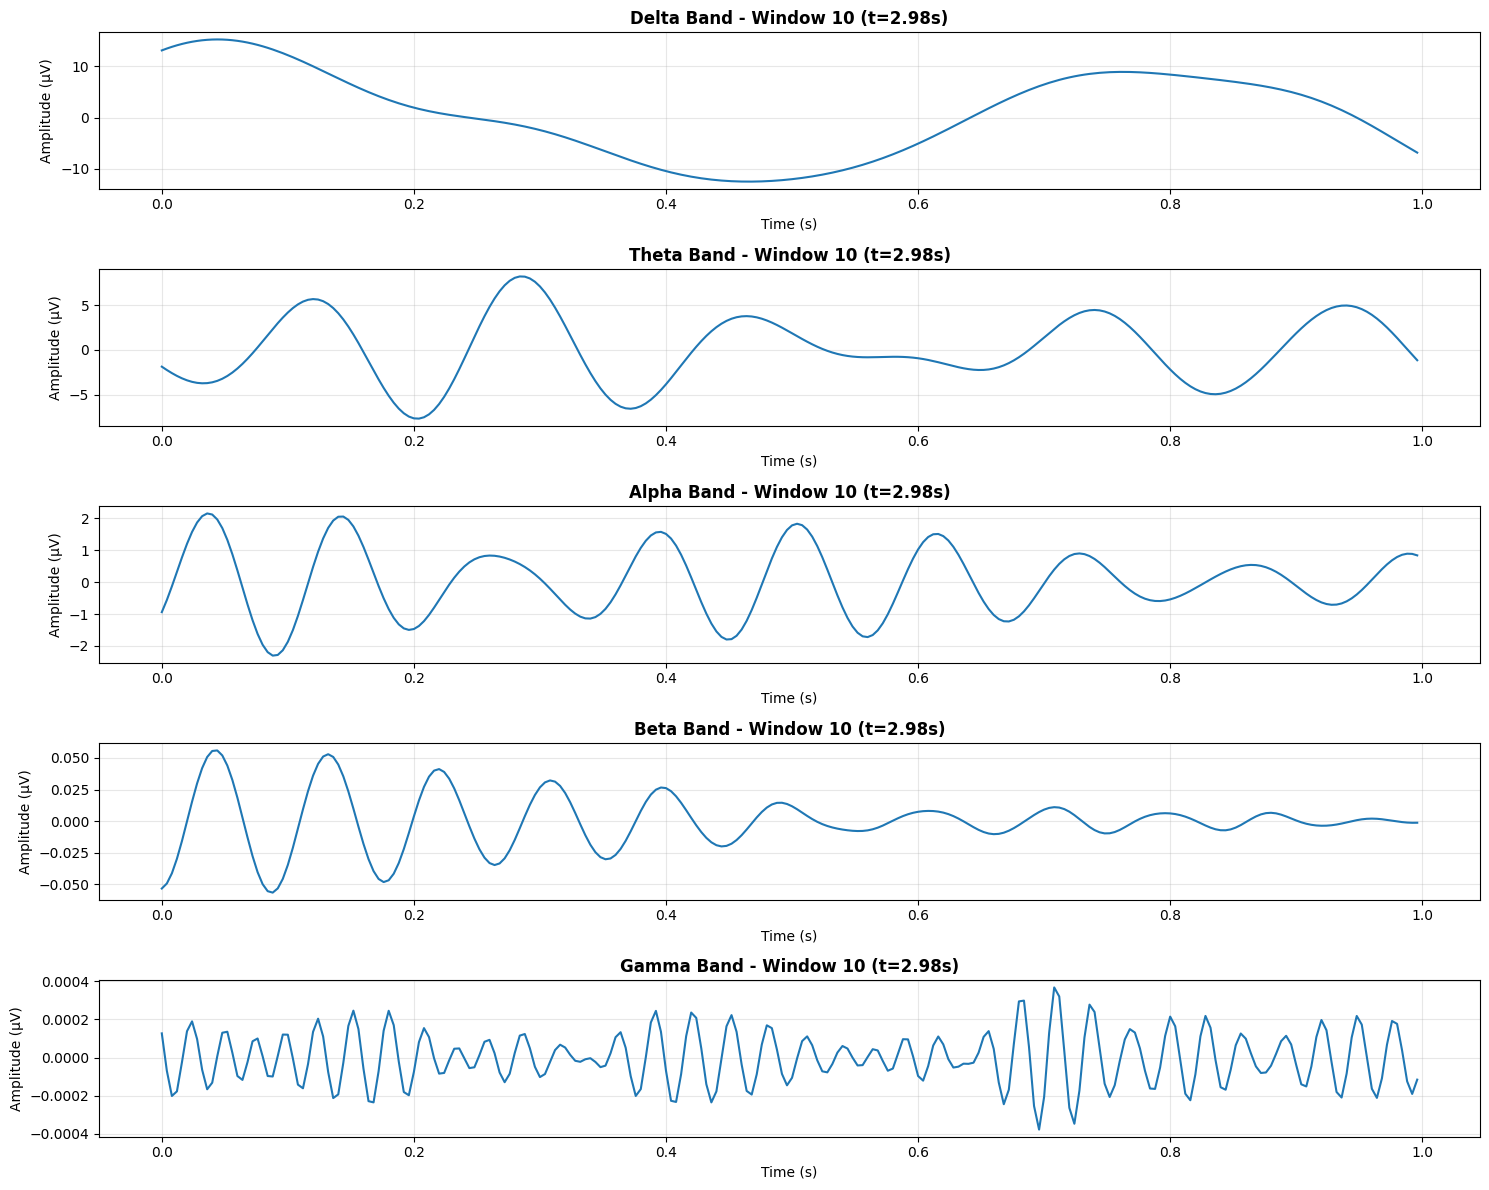


✓ Preprocessed data validated successfully!
  EEG sampling rate used: 250 Hz


In [13]:
# Create summary DataFrames
df_slow = pd.DataFrame(metadata_slow)
df_fast = pd.DataFrame(metadata_fast)

# Add condition labels
df_slow["condition"] = "slow"
df_fast["condition"] = "fast"

# Combine
df_all = pd.concat([df_slow, df_fast], ignore_index=True)

# Save metadata
df_all.to_csv(OUTPUT_DIR / "preprocessing_metadata.csv", index=False)
print(f"✓ Metadata saved to {OUTPUT_DIR / 'preprocessing_metadata.csv'}")

# Display summary statistics
print("\n" + "=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(f"\nTotal files processed: {len(df_all)}")
print(f"  Slow: {len(df_slow)}")
print(f"  Fast: {len(df_fast)}")

print(f"\nDuration statistics:")
print(f"  Mean: {df_all['duration_sec'].mean():.2f}s")
print(f"  Std: {df_all['duration_sec'].std():.2f}s")
print(f"  Min: {df_all['duration_sec'].min():.2f}s")
print(f"  Max: {df_all['duration_sec'].max():.2f}s")

print(f"\nWindows per file:")
print(f"  Mean: {df_all['n_windows'].mean():.1f}")
print(f"  Std: {df_all['n_windows'].std():.1f}")
print(f"  Min: {df_all['n_windows'].min()}")
print(f"  Max: {df_all['n_windows'].max()}")

print(f"\nTotal windows across all files:")
print(f"  Slow: {df_slow['n_windows'].sum()}")
print(f"  Fast: {df_fast['n_windows'].sum()}")
print(f"  Total: {df_all['n_windows'].sum()}")


# validacion

# Load a preprocessed file to validate
sample_preprocessed_dir = OUTPUT_DIR / "slow" / test_file.stem

print(f"Loading preprocessed data from: {sample_preprocessed_dir.name}")

# Load all bands
bands_data = {}
for band_name in FREQ_BANDS.keys():
    band_file = sample_preprocessed_dir / f"{band_name}.npy"
    if band_file.exists():
        bands_data[band_name] = np.load(band_file)
        print(f"  {band_name}: {bands_data[band_name].shape}")

window_times = np.load(sample_preprocessed_dir / "window_times.npy")

# Plot one window from each band
fig, axes = plt.subplots(5, 1, figsize=(15, 12))

window_idx = 10  # Plot 10th window
electrode_idx = 0  # First electrode

for idx, (band_name, data) in enumerate(bands_data.items()):
    time_axis = np.arange(data.shape[2]) / FS_EEG
    axes[idx].plot(time_axis, data[window_idx, electrode_idx, :], linewidth=1.5)
    axes[idx].set_title(
        f"{band_name.capitalize()} Band - Window {window_idx} (t={window_times[window_idx]:.2f}s)",
        fontweight="bold",
    )
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Amplitude (μV)")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Preprocessed data validated successfully!")
print(f"  EEG sampling rate used: {FS_EEG} Hz")

Configuración:
Datos preprocesados: preprocessed
Directorio de salida: data/graphs
Bandas de frecuencia: {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}
Número de electrodos: 47
Forma de la matriz de correlación: (47, 47)
Rango de correlación: [-0.136, 1.000]
Es simétrica: True
Forma de la matriz de distancia: (47, 47)
Rango de distancia: [0.000, 1.000]
Es simétrica: True
Testing graph construction on: bb51_ut08

✓ Graph construction test successful!
  File: bb51_ut08
  Bands processed: ['delta', 'theta', 'alpha', 'beta', 'gamma']
    delta: 73 windows
    theta: 73 windows
    alpha: 73 windows
    beta: 73 windows
    gamma: 73 windows
BUILDING GRAPHS FOR SLOW AUDIO FILES
Processing 710 files from slow...


Building graphs: 100%|██████████| 710/710 [00:32<00:00, 21.64it/s]



✓ Graph construction complete!
  Successfully processed: 710 files
  Failed: 0 files

BUILDING GRAPHS FOR FAST AUDIO FILES
Processing 706 files from fast...


Building graphs: 100%|██████████| 706/706 [00:20<00:00, 34.31it/s]



✓ Graph construction complete!
  Successfully processed: 706 files
  Failed: 0 files
Se cargaron datos del grafo: bb51_ut08
  Correlaciones de la banda alpha shape: (73, 47, 47)
  Distancias de la banda alpha shape: (73, 47, 47)
Se cargaron datos del grafo: bb14_ut03


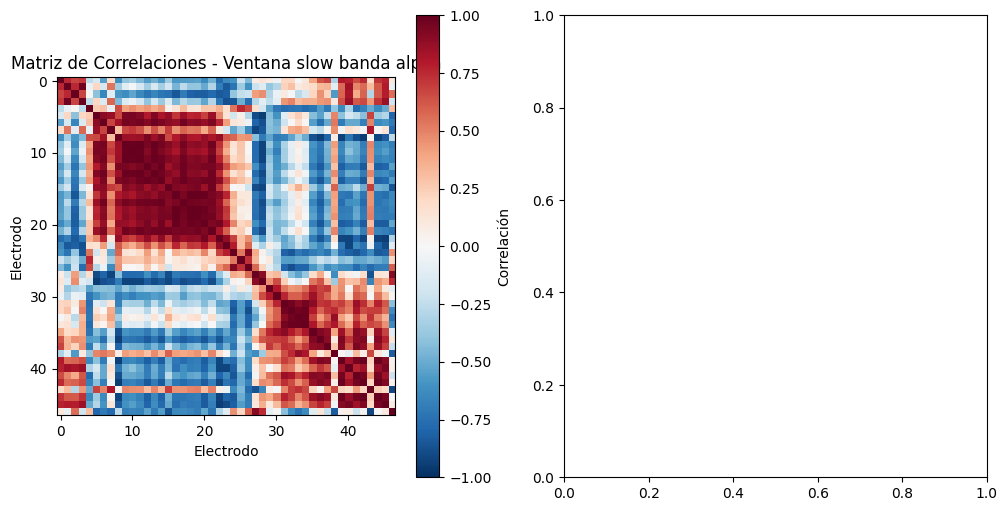

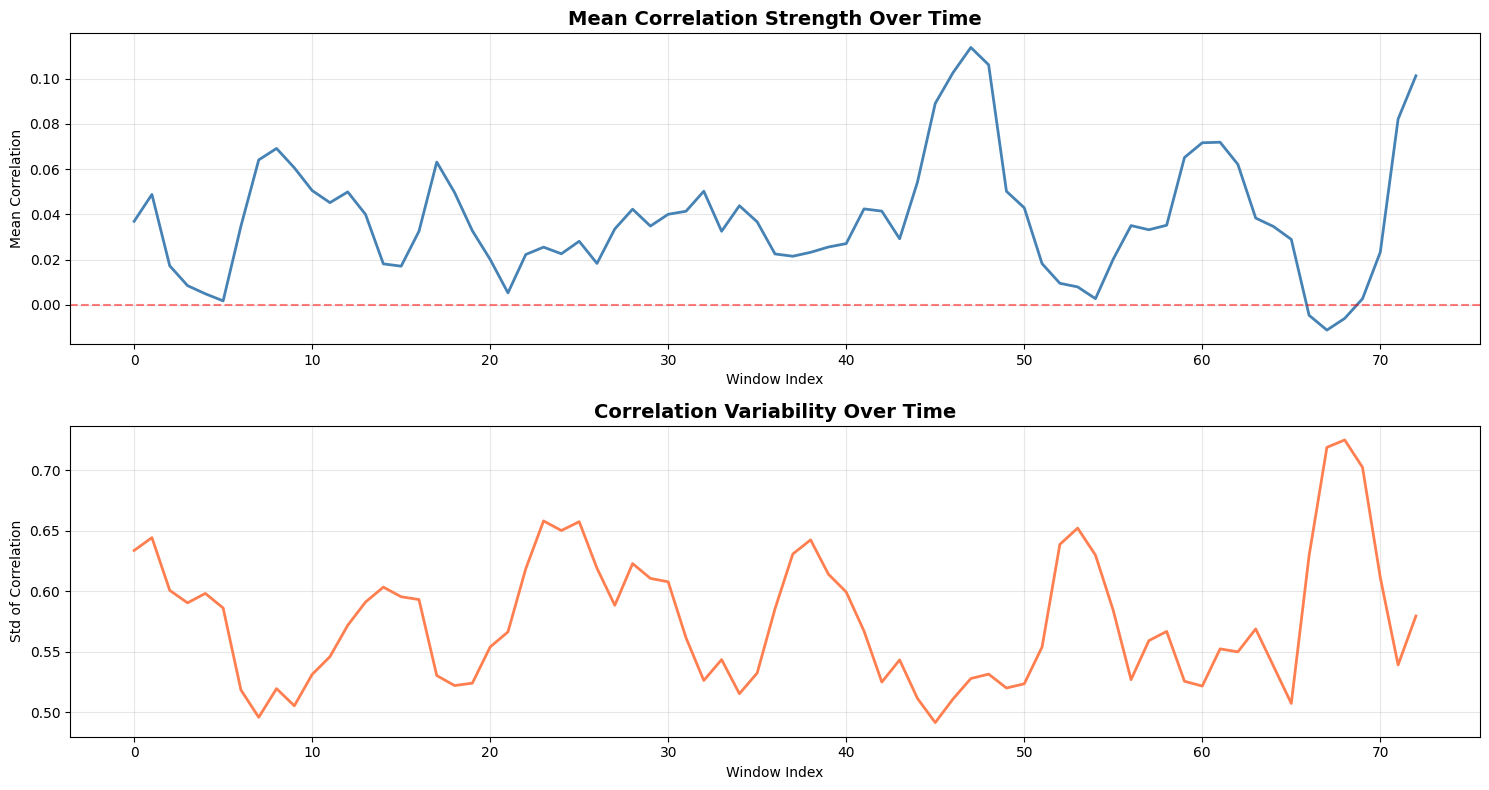

Mean correlation across all windows: 0.038
Std of mean correlations: 0.026


In [ ]:

print(f"Configuración:")
print(f"Datos preprocesados: {PREPROCESSED_DIR}")
print(f"Directorio de salida: {GRAPHS_DIR}")
print(f"Bandas de frecuencia: {FREQ_BANDS}")
print(f"Número de electrodos: {N_ELECTRODES}")


def compute_correlation_matrix(window_data):
    # Compute Pearson correlation
    corr_matrix = np.corrcoef(window_data)

    # Handle any NaN values (can occur if signal is constant)
    corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)

    return corr_matrix


def correlation_to_distance(corr_matrix, method="abs"):

    if method == "abs":
        distance_matrix = 1 - np.abs(corr_matrix)
    elif method == "standard":
        distance_matrix = 1 - corr_matrix
    elif method == "sqrt":
        distance_matrix = np.sqrt(1 - corr_matrix**2)
    else:
        raise ValueError(f"Unknown method: {method}")

    distance_matrix = np.maximum(distance_matrix, 0)
    np.fill_diagonal(distance_matrix, 0)

    return distance_matrix




test_window = np.random.randn(N_ELECTRODES, 500)  # Datos de prueba aleatorios
corr_test = compute_correlation_matrix(test_window)
dist_test = correlation_to_distance(corr_test, method="abs")

print(f"Forma de la matriz de correlación: {corr_test.shape}")
print(f"Rango de correlación: [{corr_test.min():.3f}, {corr_test.max():.3f}]")
print(f"Es simétrica: {np.allclose(corr_test, corr_test.T)}")
print(f"Forma de la matriz de distancia: {dist_test.shape}")
print(f"Rango de distancia: [{dist_test.min():.3f}, {dist_test.max():.3f}]")
print(f"Es simétrica: {np.allclose(dist_test, dist_test.T)}") 

def process_file_graphs(file_dir, output_dir, freq_bands, distance_method="abs"):
    """
    Process one file: compute correlation and distance matrices for all windows and bands.

    Parameters:
    -----------
    file_dir : Path
        Directory containing preprocessed data for one file
    output_dir : Path
        Directory to save graph data
    freq_bands : list
        List of frequency band names
    distance_method : str
        Method to convert correlation to distance

    Returns:
    --------
    metadata : dict
        Metadata about processed graphs
    """
    file_name = file_dir.name
    file_output_dir = output_dir / file_name
    file_output_dir.mkdir(parents=True, exist_ok=True)

    metadata = {"filename": file_name, "bands": {}}

    for band_name in freq_bands:
        # Load windowed data
        band_file = file_dir / f"{band_name}.npy"
        if not band_file.exists():
            continue

        windows = np.load(band_file)  # shape: (n_windows, n_electrodes, window_samples)
        n_windows = windows.shape[0]

        # Preallocate arrays for time series of matrices
        correlation_matrices = np.zeros((n_windows, N_ELECTRODES, N_ELECTRODES))
        distance_matrices = np.zeros((n_windows, N_ELECTRODES, N_ELECTRODES))

        # Process each window
        for i in range(n_windows):
            window_data = windows[i, :, :]  # shape: (n_electrodes, window_samples)

            # Compute correlation
            corr_matrix = compute_correlation_matrix(window_data)
            correlation_matrices[i, :, :] = corr_matrix

            # Convert to distance
            dist_matrix = correlation_to_distance(corr_matrix, method=distance_method)
            distance_matrices[i, :, :] = dist_matrix

        # Save matrices
        np.save(file_output_dir / f"{band_name}_correlations.npy", correlation_matrices)
        np.save(file_output_dir / f"{band_name}_distances.npy", distance_matrices)

        metadata["bands"][band_name] = {
            "n_windows": n_windows,
            "n_electrodes": N_ELECTRODES,
        }

    return metadata


# Test on one file
test_file_dir = list((PREPROCESSED_DIR / "slow").iterdir())[0]
test_file_dir2 = list((PREPROCESSED_DIR / "fast").iterdir())[0]
print(f"Testing graph construction on: {test_file_dir.name}")

metadata_test = process_file_graphs(
    test_file_dir, GRAPHS_DIR / "slow", FREQ_BANDS, distance_method="abs"
)

print(f"\n✓ Graph construction test successful!")
print(f"  File: {metadata_test['filename']}")
print(f"  Bands processed: {list(metadata_test['bands'].keys())}")
for band, info in metadata_test["bands"].items():
    print(f"    {band}: {info['n_windows']} windows")

def batch_process_graphs(input_dir, output_dir, freq_bands, distance_method="abs"):
    """
    Process all files in a directory to create graph time series.

    Parameters:
    -----------
    input_dir : Path
        Directory containing preprocessed files
    output_dir : Path
        Directory to save graph data
    freq_bands : list
        List of frequency band names
    distance_method : str
        Distance conversion method

    Returns:
    --------
    all_metadata : list
        List of metadata for all processed files
    """
    file_dirs = sorted([d for d in input_dir.iterdir() if d.is_dir()])
    all_metadata = []
    failed_files = []

    print(f"Processing {len(file_dirs)} files from {input_dir.name}...")

    for file_dir in tqdm(file_dirs, desc="Building graphs"):
        try:
            metadata = process_file_graphs(
                file_dir, output_dir, freq_bands, distance_method
            )
            all_metadata.append(metadata)
        except Exception as e:
            print(f"\nError processing {file_dir.name}: {str(e)}")
            failed_files.append(file_dir.name)

    print(f"\n✓ Graph construction complete!")
    print(f"  Successfully processed: {len(all_metadata)} files")
    print(f"  Failed: {len(failed_files)} files")

    return all_metadata, failed_files


# Process slow files
print("=" * 60)
print("BUILDING GRAPHS FOR SLOW AUDIO FILES")
print("=" * 60)
metadata_slow_graphs, failed_slow_graphs = batch_process_graphs(
    PREPROCESSED_DIR / "slow", GRAPHS_DIR / "slow", FREQ_BANDS, distance_method="abs"
)

# Process fast files
print("\n" + "=" * 60)
print("BUILDING GRAPHS FOR FAST AUDIO FILES")
print("=" * 60)
metadata_fast_graphs, failed_fast_graphs = batch_process_graphs(
    PREPROCESSED_DIR / "fast", GRAPHS_DIR / "fast", FREQ_BANDS, distance_method="abs"
)

# Cargar datos de grafo de ejemplo para visualización
ruta_archivo_ejemplo = GRAPHS_DIR / "slow" / test_file_dir.name

ruta_archivo_fasr = GRAPHS_DIR / "fast" / test_file_dir2.name


# Cargar correlaciones y distancias de la banda alpha
correlaciones_alpha = np.load(ruta_archivo_ejemplo / "alpha_correlations.npy")
distancias_alpha = np.load(ruta_archivo_ejemplo / "alpha_distances.npy")

# correlaciones_alpha2 = np.load(ruta_archivo_fasr / "alpha_correlations.npy")
# distancias_alpha2 = np.load(ruta_archivo_fasr / "alpha_distances.npy")

print("Se cargaron datos del grafo:", ruta_archivo_ejemplo.name)
print("  Correlaciones de la banda alpha shape:", correlaciones_alpha.shape)
print("  Distancias de la banda alpha shape:", distancias_alpha.shape)

print("Se cargaron datos del grafo:", ruta_archivo_fasr.name)
# print("  Correlaciones de la banda alpha shape:", correlaciones_alpha2.shape)
# print("  Distancias de la banda alpha shape:", distancias_alpha2.shape)

# Plot de matrices de correlaciones y distancias para una ventana
indice_ventana = 30

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Matriz de correlaciones
# im1 = axes[0].imshow(
#     correlaciones_alpha[indice_ventana], cmap="RdBu_r", vmin=-1, vmax=1
# )
# axes[0].set_title(
#     "Matriz de Correlaciones - Ventana slow banda alpha",
#     fontsize=12,
# )
# axes[0].set_xlabel("Electrodo")
# axes[0].set_ylabel("Electrodo")
# plt.colorbar(im1, ax=axes[0], label="Correlación")

# Matriz fast

# im2 = axes[1].imshow(
#     correlaciones_alpha2[indice_ventana], cmap="RdBu_r", vmin=-1, vmax=1
# )
# axes[1].set_title(
#     "Matriz de Correlaciones - Ventana fast banda alfa",
#     fontsize=12,
# )
# axes[1].set_xlabel("Electrodo")
# axes[1].set_ylabel("Electrodo")
# plt.colorbar(im2, ax=axes[1], label="Correlación")

# plt.tight_layout()
# plt.show()


# Analyze how connectivity changes over time
# Compute average correlation strength for each window

mean_corr_per_window = []
std_corr_per_window = []

for i in range(correlaciones_alpha.shape[0]):
    # Get upper triangle (exclude diagonal)
    upper_tri = correlaciones_alpha[i][np.triu_indices(N_ELECTRODES, k=1)]
    mean_corr_per_window.append(np.mean(upper_tri))
    std_corr_per_window.append(np.std(upper_tri))

mean_corr_per_window = np.array(mean_corr_per_window)
std_corr_per_window = np.array(std_corr_per_window)

# Plot temporal evolution
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Mean correlation over time
axes[0].plot(mean_corr_per_window, linewidth=2, color="steelblue")
axes[0].set_title("Mean Correlation Strength Over Time", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Window Index")
axes[0].set_ylabel("Mean Correlation")
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color="r", linestyle="--", alpha=0.5)

# Std correlation over time
axes[1].plot(std_corr_per_window, linewidth=2, color="coral")
axes[1].set_title("Correlation Variability Over Time", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Window Index")
axes[1].set_ylabel("Std of Correlation")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean correlation across all windows: {mean_corr_per_window.mean():.3f}")
print(f"Std of mean correlations: {mean_corr_per_window.std():.3f}")

# pipeline clasificacion


In [ ]:

DIRECTORIO_GRAFOS = Path("data/graphs")  # Match GRAPHS_DIR from Cell 1
DIRECTORIO_CARACTERISTICAS = Path("caracteristicas")
DIRECTORIO_RESULTADOS = Path("resultados")
DIRECTORIO_CARACTERISTICAS.mkdir(exist_ok=True)
DIRECTORIO_RESULTADOS.mkdir(exist_ok=True)

# Bandas de frecuencia - cada una captura diferente actividad neural
BANDAS_FRECUENCIA = ["delta", "theta", "alpha", "beta", "gamma"]
RANGOS_BANDAS = {
    "delta": "0.5-4 Hz (sueño profundo, atención)",
    "theta": "4-8 Hz (somnolencia, memoria)",
    "alpha": "8-13 Hz (relajación, inhibición)",
    "beta": "13-30 Hz (alerta, pensamiento activo)",
    "gamma": "30-100 Hz (percepción, cognición)",
}

# Parámetros TDA
DIMENSION_MAXIMA = 1  # Calcular H0 (componentes conexas) y H1 (ciclos/agujeros)
# Nota: LONGITUD_ARISTA_MAXIMA debe ajustarse según tu métrica de distancia
# Si usas distancia de correlación (1 - |corr|): rango es [0, 1], usar ~1.0
# Si usas otras métricas, ajustar correspondientemente
LONGITUD_ARISTA_MAXIMA = 1.0  # Valor máximo de filtración para complejo de Rips

# Parámetros de clasificación
N_PARTICIONES = 5  # Número de folds para GroupKFold CV
N_PERMUTACIONES = 1000  # Para prueba de permutación
N_BOOTSTRAP = 1000  # Para intervalos de confianza
SEMILLA_ALEATORIA = 42

print("Configuración:")
print(f"  Directorio de grafos: {DIRECTORIO_GRAFOS}")
print(f"  Salida de características: {DIRECTORIO_CARACTERISTICAS}")
print(f"  Salida de resultados: {DIRECTORIO_RESULTADOS}")
print(f"\nBandas de frecuencia:")
for banda, descripcion in RANGOS_BANDAS.items():
    print(f"  {banda}: {descripcion}")
print(f"\nParámetros TDA:")
print(f"  Dimensión homológica máxima: H{DIMENSION_MAXIMA}")
print(f"  Longitud máxima de arista (filtración): {LONGITUD_ARISTA_MAXIMA}")
print(f"\nParámetros de clasificación:")
print(f"  Particiones CV: {N_PARTICIONES}")
print(f"  Iteraciones de permutación: {N_PERMUTACIONES}")
print(f"  Iteraciones bootstrap: {N_BOOTSTRAP}")

Configuración:
  Directorio de grafos: data/graphs
  Salida de características: caracteristicas
  Salida de resultados: resultados

Bandas de frecuencia:
  delta: 0.5-4 Hz (sueño profundo, atención)
  theta: 4-8 Hz (somnolencia, memoria)
  alpha: 8-13 Hz (relajación, inhibición)
  beta: 13-30 Hz (alerta, pensamiento activo)
  gamma: 30-100 Hz (percepción, cognición)

Parámetros TDA:
  Dimensión homológica máxima: H1
  Longitud máxima de arista (filtración): 2.0

Parámetros de clasificación:
  Particiones CV: 5
  Iteraciones de permutación: 1000
  Iteraciones bootstrap: 1000


#### features percistencia



Probando Pipeline TDA

Generando matriz de distancia de ejemplo...
Validación de matriz de distancia: PASÓ

Diagramas de persistencia calculados:
  H0 (componentes conexas): 47 características
  H1 (ciclos/agujeros): 95 características

Características extraídas:
  H0: 11 características escalares
  H1: 11 características escalares
  Total por banda: 22 características


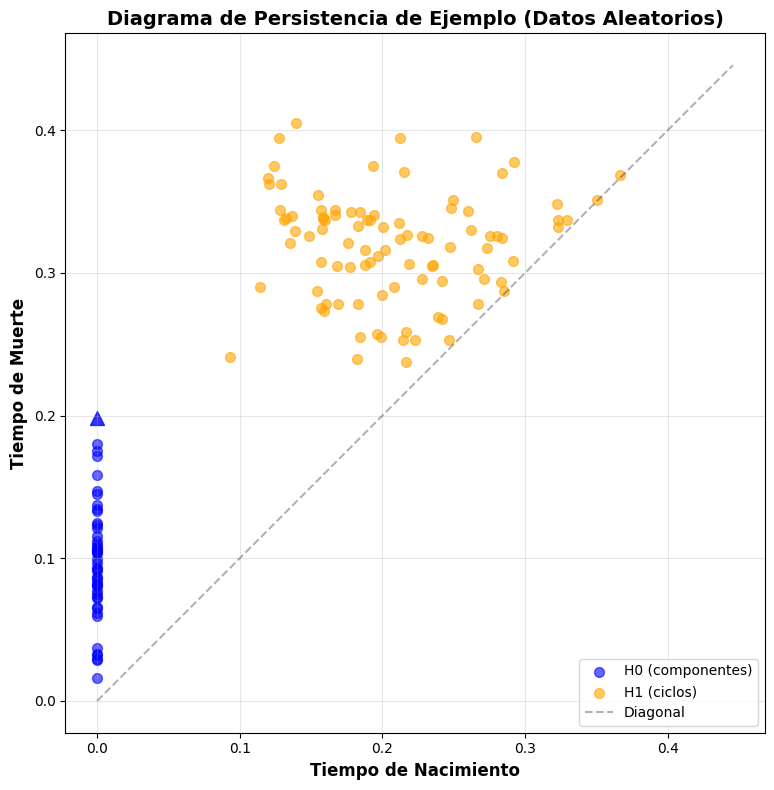

Explicación del diagrama de persistencia:
  - Cada punto representa una característica topológica
  - Eje X (nacimiento): umbral de distancia donde aparece la característica
  - Eje Y (muerte): umbral de distancia donde desaparece la característica
  - Distancia a la diagonal = persistencia = importancia
  - H0: componentes conexas (cómo se fragmenta el grafo)
  - H1: ciclos/agujeros (patrones de conectividad circular)


In [ ]:
def validar_matriz_distancia(matriz_distancia, nombre=""):
    """
    Validar que una matriz sea una matriz de distancia válida.
    
    Requisitos:
    - Matriz cuadrada
    - Simétrica (o casi simétrica)
    - Valores no negativos
    - Diagonal cero
    
    Parámetros:
    -----------
    matriz_distancia : ndarray
        Matriz a validar
    nombre : str
        Nombre para mensajes de error
        
    Retorna:
    --------
    es_valida : bool
    problemas : lista de str
    """
    problemas = []
    
    # Verificar cuadrada
    if matriz_distancia.ndim != 2:
        problemas.append(f"No es 2D: forma={matriz_distancia.shape}")
        return False, problemas
    
    n, m = matriz_distancia.shape
    if n != m:
        problemas.append(f"No es cuadrada: forma=({n}, {m})")
        return False, problemas
    
    # Verificar simetría (con tolerancia para punto flotante)
    if not np.allclose(matriz_distancia, matriz_distancia.T, rtol=1e-5, atol=1e-8):
        diferencia_max = np.max(np.abs(matriz_distancia - matriz_distancia.T))
        problemas.append(f"No es simétrica: asimetría máxima={diferencia_max:.6f}")
    
    # Verificar no negativo
    if np.any(matriz_distancia < -1e-10):  # Pequeña tolerancia para errores numéricos
        valor_min = np.min(matriz_distancia)
        problemas.append(f"Valores negativos presentes: mín={valor_min:.6f}")
    
    # Verificar diagonal
    diagonal = np.diag(matriz_distancia)
    if not np.allclose(diagonal, 0, atol=1e-10):
        diagonal_max = np.max(np.abs(diagonal))
        problemas.append(f"Diagonal no cero: máx={diagonal_max:.6f}")
    
    # Verificar NaN/Inf
    if np.any(np.isnan(matriz_distancia)):
        problemas.append("Contiene valores NaN")
    if np.any(np.isinf(matriz_distancia)):
        problemas.append("Contiene valores Inf")
    
    es_valida = len(problemas) == 0
    return es_valida, problemas


def calcular_diagrama_persistencia(matriz_distancia, dim_max=1, longitud_arista_max=2.0):
    """
    Calcular diagrama de persistencia desde matriz de distancia usando Ripser.
    
    El diagrama de persistencia captura características topológicas (componentes, ciclos)
    que aparecen y desaparecen al aumentar el umbral de distancia.
    
    Parámetros:
    -----------
    matriz_distancia : ndarray, forma (n, n)
        Matriz de distancia simétrica con diagonal cero
    dim_max : int
        Dimensión homológica máxima (1 = H0 y H1)
    longitud_arista_max : float
        Longitud máxima de arista para filtración del complejo de Rips
        
    Retorna:
    --------
    diagramas : lista de ndarray
        Diagramas de persistencia para cada dimensión [H0, H1, ...]
        Cada diagrama tiene forma (n_caracteristicas, 2) con pares (nacimiento, muerte)
    """
    # Asegurar que la matriz sea simétrica (promediar si hay pequeñas diferencias)
    matriz_distancia = (matriz_distancia + matriz_distancia.T) / 2
    np.fill_diagonal(matriz_distancia, 0)
    
    # Recortar valores negativos pequeños de errores numéricos
    matriz_distancia = np.maximum(matriz_distancia, 0)
    
    resultado = ripser(
        matriz_distancia,
        maxdim=dim_max,
        thresh=longitud_arista_max,
        distance_matrix=True
    )
    return resultado["dgms"]


def extraer_caracteristicas_persistencia(diagrama, nombre_dim=""):
    """
    Extraer características escalares de un diagrama de persistencia.
    
    Las características capturan diferentes aspectos de la estructura topológica:
    - Conteo: Cuántas características existen
    - Tiempos de nacimiento/muerte: Cuándo aparecen/desaparecen las características
    - Persistencia: Cuánto duran las características (muerte - nacimiento)
    - Entropía: Distribución de valores de persistencia
    
    Parámetros:
    -----------
    diagrama : ndarray, forma (n_caracteristicas, 2)
        Diagrama de persistencia con pares (nacimiento, muerte)
    nombre_dim : str
        Nombre de la dimensión para nombrar características
        
    Retorna:
    --------
    caracteristicas : dict
        Diccionario de características escalares extraídas
    """
    # Remover tiempos de muerte infinitos (características esenciales que nunca mueren)
    mascara_finita = np.isfinite(diagrama).all(axis=1)
    diagrama_finito = diagrama[mascara_finita]
    
    # Contar características esenciales (aquellas con persistencia infinita)
    n_esenciales = np.sum(~mascara_finita)
    
    if len(diagrama_finito) == 0:
        # Sin características finitas - retornar ceros
        return {
            "n_caracteristicas": 0,
            "n_esenciales": n_esenciales,
            "media_nacimiento": 0,
            "std_nacimiento": 0,
            "media_muerte": 0,
            "std_muerte": 0,
            "media_persistencia": 0,
            "std_persistencia": 0,
            "max_persistencia": 0,
            "total_persistencia": 0,
            "entropia_persistencia": 0,
        }
    
    nacimientos = diagrama_finito[:, 0]
    muertes = diagrama_finito[:, 1]
    persistencia = muertes - nacimientos
    
    # Calcular entropía de persistencia (normalizada)
    # Mayor entropía = distribución más uniforme de valores de persistencia
    if len(persistencia) > 1 and np.sum(persistencia) > 0:
        p_normalizada = persistencia / np.sum(persistencia)
        p_normalizada = p_normalizada[p_normalizada > 0]  # Remover ceros para log
        entropia = -np.sum(p_normalizada * np.log(p_normalizada + 1e-10))
        # Normalizar por entropía máxima posible
        entropia = entropia / np.log(len(persistencia) + 1e-10)
    else:
        entropia = 0
    
    caracteristicas = {
        "n_caracteristicas": len(diagrama_finito),
        "n_esenciales": n_esenciales,
        "media_nacimiento": np.mean(nacimientos),
        "std_nacimiento": np.std(nacimientos) if len(nacimientos) > 1 else 0,
        "media_muerte": np.mean(muertes),
        "std_muerte": np.std(muertes) if len(muertes) > 1 else 0,
        "media_persistencia": np.mean(persistencia),
        "std_persistencia": np.std(persistencia) if len(persistencia) > 1 else 0,
        "max_persistencia": np.max(persistencia),
        "total_persistencia": np.sum(persistencia),
        "entropia_persistencia": entropia,
    }
    
    return caracteristicas


# Probar con datos de ejemplo
# print("\n" + "=" * 60)
# print("Probando Pipeline TDA")
# print("=" * 60)

# print("\nGenerando matriz de distancia de ejemplo...")
# np.random.seed(42)
# dist_prueba = np.random.rand(47, 47)
# dist_prueba = (dist_prueba + dist_prueba.T) / 2  # Hacer simétrica
# np.fill_diagonal(dist_prueba, 0)

# # Validar
# es_valida, problemas = validar_matriz_distancia(dist_prueba, "prueba")
# print(f"Validación de matriz de distancia: {'PASÓ' if es_valida else 'FALLÓ'}")
# if problemas:
#     for problema in problemas:
#         print(f"  - {problema}")

# # Calcular persistencia
# diagramas_prueba = calcular_diagrama_persistencia(dist_prueba, DIMENSION_MAXIMA, LONGITUD_ARISTA_MAXIMA)
# print(f"\nDiagramas de persistencia calculados:")
# print(f"  H0 (componentes conexas): {len(diagramas_prueba[0])} características")
# print(f"  H1 (ciclos/agujeros): {len(diagramas_prueba[1])} características")

# # Extraer características
# caract_h0 = extraer_caracteristicas_persistencia(diagramas_prueba[0], "H0")
# caract_h1 = extraer_caracteristicas_persistencia(diagramas_prueba[1], "H1")
# print(f"\nCaracterísticas extraídas:")
# print(f"  H0: {len(caract_h0)} características escalares")
# print(f"  H1: {len(caract_h1)} características escalares")
# print(f"  Total por banda: {len(caract_h0) + len(caract_h1)} características")


def graficar_diagrama_persistencia(diagramas, titulo="Diagrama de Persistencia", ax=None):
    """
    Graficar diagrama de persistencia con tiempos de nacimiento vs muerte.
    
    Puntos lejos de la diagonal = características persistentes (importantes)
    Puntos cerca de la diagonal = ruido (características de corta vida)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    colores = ['blue', 'orange', 'green']
    etiquetas = ['H0 (componentes)', 'H1 (ciclos)', 'H2']
    
    valor_max = 0
    for dim, dgm in enumerate(diagramas):
        if len(dgm) > 0:
            mascara_finita = np.isfinite(dgm).all(axis=1)
            dgm_finito = dgm[mascara_finita]
            
            if len(dgm_finito) > 0:
                ax.scatter(
                    dgm_finito[:, 0], dgm_finito[:, 1],
                    c=colores[dim], label=etiquetas[dim], alpha=0.6, s=50
                )
                valor_max = max(valor_max, dgm_finito.max())
            
            # Graficar características esenciales (muerte infinita) arriba
            esenciales = dgm[~mascara_finita]
            if len(esenciales) > 0:
                ax.scatter(
                    esenciales[:, 0], 
                    [valor_max * 1.1] * len(esenciales),
                    c=colores[dim], marker='^', s=100, alpha=0.8
                )
    
    # Línea diagonal (nacimiento = muerte)
    ax.plot([0, valor_max * 1.1], [0, valor_max * 1.1], 'k--', alpha=0.3, label='Diagonal')
    
    ax.set_xlabel('Tiempo de Nacimiento', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tiempo de Muerte', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return ax


# Visualizar diagrama de persistencia de prueba
# fig, ax = plt.subplots(figsize=(8, 8))
# graficar_diagrama_persistencia(diagramas_prueba, "Diagrama de Persistencia de Ejemplo (Datos Aleatorios)", ax)
# plt.tight_layout()
# plt.savefig(DIRECTORIO_RESULTADOS / "diagrama_persistencia_ejemplo.png", dpi=150)
# plt.show()

# probar con datos validos de distancia
# print("\n" + "=" * 60)
# print("Probando Diagrama de Persistencia con Datos Reales")
# print("=" * 60)
# distancia_ejemplo = distancias_alpha[10]  # Usar la ventana 10 como ejemplo
# es_valida, problemas = validar_matriz_distancia(distancia_ejemplo, "ejemplo real")
# print(f"Validación de matriz de distancia: {'PASÓ' if es_valida else 'FALLÓ'}")
# if problemas:
#     for problema in problemas:
#         print(f"  - {problema}")
# diagramas_ejemplo = calcular_diagrama_persistencia(distancia_ejemplo, DIMENSION_MAXIMA, LONGITUD_ARISTA_MAXIMA)
# print(f"\nDiagramas de persistencia calculados:")
# print(f"  H0 (componentes conexas): {len(diagramas_ejemplo[0])} características")
# print(f"  H1 (ciclos/agujeros): {len(diagramas_ejemplo[1])} características")
# fig, ax = plt.subplots(figsize=(8, 8))
# graficar_diagrama_persistencia(diagramas_ejemplo, "Diagrama de Persistencia (Ventana Ejemplo)", ax)
# plt.tight_layout()
# plt.show()


# print("Explicación del diagrama de persistencia:")
# print("  - Cada punto representa una característica topológica")
# print("  - Eje X (nacimiento): umbral de distancia donde aparece la característica")
# print("  - Eje Y (muerte): umbral de distancia donde desaparece la característica")
# print("  - Distancia a la diagonal = persistencia = importancia")
# print("  - H0: componentes conexas (cómo se fragmenta el grafo)")
# print("  - H1: ciclos/agujeros (patrones de conectividad circular)")

#### extraer features


In [17]:
def procesar_caracteristicas_archivo(directorio_archivo, bandas_frecuencia, dim_max=1, longitud_arista_max=2.0, verbose=False):
    """
    Procesar un archivo: calcular características TDA para todas las ventanas y bandas.
    
    Para cada banda de frecuencia:
    1. Cargar matrices de distancia para todas las ventanas de tiempo
    2. Calcular diagrama de persistencia para cada ventana
    3. Extraer características escalares de cada diagrama
    4. Agregar características a través de ventanas (media/std)
    
    Parámetros:
    -----------
    directorio_archivo : Path
        Directorio que contiene matrices de distancia para un archivo
    bandas_frecuencia : lista
        Lista de nombres de bandas de frecuencia
    dim_max : int
        Dimensión homológica máxima
    longitud_arista_max : float
        Longitud máxima de arista para filtración de Rips
    verbose : bool
        Imprimir progreso detallado
        
    Retorna:
    --------
    diccionario_caracteristicas : dict
        Características agregadas para este archivo
    metadatos : dict
        Información sobre el procesamiento (n_ventanas por banda, problemas de validación)
    """
    caracteristicas_archivo = {}
    metadatos = {"n_ventanas": {}, "problemas_validacion": []}
    
    for banda in bandas_frecuencia:
        archivo_dist = directorio_archivo / f"{banda}_distances.npy"
        if not archivo_dist.exists():
            if verbose:
                print(f"  Advertencia: {banda}_distances.npy no encontrado")
            metadatos["n_ventanas"][banda] = 0
            continue
        
        # Cargar matrices de distancia (n_ventanas, n_electrodos, n_electrodos)
        try:
            matrices_distancia = np.load(archivo_dist)
        except Exception as e:
            metadatos["problemas_validacion"].append(f"{banda}: error de carga - {e}")
            continue
        
        n_ventanas = matrices_distancia.shape[0]
        metadatos["n_ventanas"][banda] = n_ventanas
        
        if n_ventanas == 0:
            if verbose:
                print(f"  Advertencia: {banda} tiene 0 ventanas")
            continue
        
        # Validar primera matriz
        es_valida, problemas = validar_matriz_distancia(matrices_distancia[0], f"{banda}[0]")
        if not es_valida:
            metadatos["problemas_validacion"].extend([f"{banda}: {p}" for p in problemas])
            # Continuar de todos modos - intentaremos arreglar en calcular_diagrama_persistencia
        
        # Recolectar características de todas las ventanas
        lista_caracteristicas_h0 = []
        lista_caracteristicas_h1 = []
        
        for i in range(n_ventanas):
            matriz_dist = matrices_distancia[i]
            
            try:
                # Calcular diagramas de persistencia
                diagramas = calcular_diagrama_persistencia(
                    matriz_dist, dim_max, longitud_arista_max
                )
                
                # Extraer características
                caract_h0 = extraer_caracteristicas_persistencia(diagramas[0], "H0")
                caract_h1 = extraer_caracteristicas_persistencia(diagramas[1], "H1")
                
                lista_caracteristicas_h0.append(caract_h0)
                lista_caracteristicas_h1.append(caract_h1)
                
            except Exception as e:
                if verbose:
                    print(f"  Error en {banda} ventana {i}: {e}")
                continue
        
        # Verificar si obtuvimos características válidas
        if len(lista_caracteristicas_h0) == 0:
            if verbose:
                print(f"  Advertencia: Sin ventanas válidas para {banda}")
            continue
        
        # Agregar a través de ventanas (media y std)
        for nombre_caract in lista_caracteristicas_h0[0].keys():
            valores_h0 = [c[nombre_caract] for c in lista_caracteristicas_h0]
            caracteristicas_archivo[f"{banda}_h0_{nombre_caract}_media"] = np.mean(valores_h0)
            caracteristicas_archivo[f"{banda}_h0_{nombre_caract}_std"] = np.std(valores_h0)
            
            valores_h1 = [c[nombre_caract] for c in lista_caracteristicas_h1]
            caracteristicas_archivo[f"{banda}_h1_{nombre_caract}_media"] = np.mean(valores_h1)
            caracteristicas_archivo[f"{banda}_h1_{nombre_caract}_std"] = np.std(valores_h1)
    
    return caracteristicas_archivo, metadatos


# Probar en un archivo
print("\n" + "=" * 60)
print("Probando Extracción de Características en Datos Reales")
print("=" * 60)

directorios_lento = list((DIRECTORIO_GRAFOS / "slow").iterdir())
if len(directorios_lento) > 0:
    directorio_grafo_prueba = directorios_lento[0]
    print(f"Probando en: {directorio_grafo_prueba.name}")
    
    caracteristicas_prueba, metadatos_prueba = procesar_caracteristicas_archivo(
        directorio_grafo_prueba, BANDAS_FRECUENCIA, DIMENSION_MAXIMA, LONGITUD_ARISTA_MAXIMA, verbose=True
    )
    
    print(f"\nResultados de extracción de características:")
    print(f"  Total de características: {len(caracteristicas_prueba)}")
    print(f"  Ventanas por banda: {metadatos_prueba['n_ventanas']}")
    if metadatos_prueba['problemas_validacion']:
        print(f"  Problemas de validación: {metadatos_prueba['problemas_validacion']}")
    print(f"  Características de ejemplo: {list(caracteristicas_prueba.keys())[:5]}")
else:
    print("No se encontraron datos en el directorio graphs/slow")

def crear_conjunto_datos(dir_grafos_lento, dir_grafos_rapido, bandas_frecuencia, dim_max=1, longitud_arista_max=2.0):
    """
    Crear conjunto de datos completo desde todos los archivos.
    
    Extrae IDs de sujetos de los nombres de archivo para validación cruzada apropiada.
    Formato de nombre de archivo esperado: bbXX_utYY (sujeto_ensayo)
    
    Retorna:
    --------
    X : ndarray (n_muestras, n_caracteristicas)
    y : ndarray (n_muestras,) - 0=lento, 1=rápido
    sujetos : ndarray (n_muestras,) - IDs de sujetos
    nombres_caracteristicas : lista
    nombres_archivos : lista
    todos_metadatos : lista de dicts
    """
    todas_caracteristicas = []
    todas_etiquetas = []
    todos_sujetos = []
    todos_nombres_archivos = []
    todos_metadatos = []
    
    # Procesar archivos lentos (etiqueta = 0)
    directorios_lento = sorted([d for d in dir_grafos_lento.iterdir() if d.is_dir()])
    print(f"\nProcesando {len(directorios_lento)} archivos de audio LENTO...")
    
    for directorio_archivo in tqdm(directorios_lento, desc="Lento"):
        try:
            caracteristicas, metadatos = procesar_caracteristicas_archivo(
                directorio_archivo, bandas_frecuencia, dim_max, longitud_arista_max
            )
            if len(caracteristicas) > 0:
                todas_caracteristicas.append(caracteristicas)
                todas_etiquetas.append(0)  # lento = 0
                
                # Extraer ID de sujeto (formato: bbXX_utYY)
                nombre_archivo = directorio_archivo.name
                partes = nombre_archivo.split("_")
                id_sujeto = partes[0] if len(partes) > 0 else nombre_archivo
                
                todos_sujetos.append(id_sujeto)
                todos_nombres_archivos.append(nombre_archivo)
                todos_metadatos.append(metadatos)
        except Exception as e:
            print(f"Error procesando {directorio_archivo.name}: {e}")
    
    # Procesar archivos rápidos (etiqueta = 1)
    directorios_rapido = sorted([d for d in dir_grafos_rapido.iterdir() if d.is_dir()])
    print(f"Procesando {len(directorios_rapido)} archivos de audio RÁPIDO...")
    
    for directorio_archivo in tqdm(directorios_rapido, desc="Rápido"):
        try:
            caracteristicas, metadatos = procesar_caracteristicas_archivo(
                directorio_archivo, bandas_frecuencia, dim_max, longitud_arista_max
            )
            if len(caracteristicas) > 0:
                todas_caracteristicas.append(caracteristicas)
                todas_etiquetas.append(1)  # rápido = 1
                
                nombre_archivo = directorio_archivo.name
                partes = nombre_archivo.split("_")
                id_sujeto = partes[0] if len(partes) > 0 else nombre_archivo
                
                todos_sujetos.append(id_sujeto)
                todos_nombres_archivos.append(nombre_archivo)
                todos_metadatos.append(metadatos)
        except Exception as e:
            print(f"Error procesando {directorio_archivo.name}: {e}")
    
    # Convertir a arrays
    df_caracteristicas = pd.DataFrame(todas_caracteristicas)
    nombres_caracteristicas = list(df_caracteristicas.columns)
    X = df_caracteristicas.values
    y = np.array(todas_etiquetas)
    sujetos = np.array(todos_sujetos)
    
    print(f"\n{'=' * 60}")
    print("Resumen del Conjunto de Datos")
    print("=" * 60)
    print(f"Total de muestras: {X.shape[0]}")
    print(f"Total de características: {X.shape[1]}")
    print(f"  Características por banda: {X.shape[1] // len(bandas_frecuencia)}")
    print(f"\nDistribución de clases:")
    print(f"  Lento (0): {np.sum(y == 0)} muestras ({np.sum(y == 0) / len(y) * 100:.1f}%)")
    print(f"  Rápido (1): {np.sum(y == 1)} muestras ({np.sum(y == 1) / len(y) * 100:.1f}%)")
    print(f"\nDistribución de sujetos:")
    print(f"  Sujetos únicos: {len(np.unique(sujetos))}")
    
    return X, y, sujetos, nombres_caracteristicas, todos_nombres_archivos, todos_metadatos


# Crear conjunto de datos
print("\n" + "=" * 60)
print("Creando Conjunto de Datos Completo")
print("=" * 60)

X, y, sujetos, nombres_caracteristicas, nombres_archivos, todos_metadatos = crear_conjunto_datos(
    DIRECTORIO_GRAFOS / "slow",
    DIRECTORIO_GRAFOS / "fast",
    BANDAS_FRECUENCIA,
    DIMENSION_MAXIMA,
    LONGITUD_ARISTA_MAXIMA
)

# Guardar conjunto de datos
np.save(DIRECTORIO_CARACTERISTICAS / "X.npy", X)
np.save(DIRECTORIO_CARACTERISTICAS / "y.npy", y)
np.save(DIRECTORIO_CARACTERISTICAS / "sujetos.npy", sujetos)

with open(DIRECTORIO_CARACTERISTICAS / "nombres_caracteristicas.txt", "w") as f:
    for nombre in nombres_caracteristicas:
        f.write(f"{nombre}\n")

with open(DIRECTORIO_CARACTERISTICAS / "nombres_archivos.txt", "w") as f:
    for nombre in nombres_archivos:
        f.write(f"{nombre}\n")

print(f"\nConjunto de datos guardado en {DIRECTORIO_CARACTERISTICAS}")

print("\n" + "=" * 60)
print("Preprocesamiento de Datos")
print("=" * 60)

# Verificar valores NaN/Inf
print("\nVerificando valores inválidos...")
conteo_nan = np.isnan(X).sum()
conteo_inf = np.isinf(X).sum()
print(f"  Valores NaN: {conteo_nan}")
print(f"  Valores Inf: {conteo_inf}")

# Manejar valores problemáticos
mascara_nan = np.isnan(X).any(axis=1)
mascara_inf = np.isinf(X).any(axis=1)
mascara_valida = ~(mascara_nan | mascara_inf)

n_eliminados = (~mascara_valida).sum()
if n_eliminados > 0:
    print(f"\nEliminando {n_eliminados} muestras con valores inválidos...")
    X = X[mascara_valida]
    y = y[mascara_valida]
    sujetos = sujetos[mascara_valida]
    nombres_archivos = [f for f, v in zip(nombres_archivos, mascara_valida) if v]

print(f"\nConjunto de datos limpio: {X.shape[0]} muestras, {X.shape[1]} características")

# Analizar distribuciones de características
print("\nEstadísticas de características:")
print(f"  Valor mínimo: {X.min():.4f}")
print(f"  Valor máximo: {X.max():.4f}")
print(f"  Media: {X.mean():.4f}")
print(f"  Desviación estándar: {X.std():.4f}")

# Verificar características constantes (varianza cero)
stds_caracteristicas = X.std(axis=0)
caracteristicas_constantes = stds_caracteristicas < 1e-10
n_constantes = caracteristicas_constantes.sum()
if n_constantes > 0:
    print(f"\nAdvertencia: {n_constantes} características tienen varianza cero")
    print("  Estas no serán informativas para la clasificación")
    nombres_constantes = [nombres_caracteristicas[i] for i in np.where(caracteristicas_constantes)[0]]
    print(f"  Características constantes: {nombres_constantes[:5]}...")

# Estandarizar características
# escalador = StandardScaler()
# X_escalado = escalador.fit_transform(X)

# print("\nCaracterísticas estandarizadas (media=0, std=1)")


Probando Extracción de Características en Datos Reales
Probando en: bb51_ut08

Resultados de extracción de características:
  Total de características: 220
  Ventanas por banda: {'delta': 73, 'theta': 73, 'alpha': 73, 'beta': 73, 'gamma': 73}
  Características de ejemplo: ['delta_h0_n_caracteristicas_media', 'delta_h0_n_caracteristicas_std', 'delta_h1_n_caracteristicas_media', 'delta_h1_n_caracteristicas_std', 'delta_h0_n_esenciales_media']

Creando Conjunto de Datos Completo

Procesando 710 archivos de audio LENTO...


Lento: 100%|██████████| 710/710 [02:24<00:00,  4.92it/s]


Procesando 706 archivos de audio RÁPIDO...


Rápido: 100%|██████████| 706/706 [01:27<00:00,  8.03it/s]


Resumen del Conjunto de Datos
Total de muestras: 1416
Total de características: 220
  Características por banda: 44

Distribución de clases:
  Lento (0): 710 muestras (50.1%)
  Rápido (1): 706 muestras (49.9%)

Distribución de sujetos:
  Sujetos únicos: 45

Conjunto de datos guardado en caracteristicas

Preprocesamiento de Datos

Verificando valores inválidos...
  Valores NaN: 0
  Valores Inf: 0

Conjunto de datos limpio: 1416 muestras, 220 características

Estadísticas de características:
  Valor mínimo: 0.0000
  Valor máximo: 46.0000
  Media: 1.7678
  Desviación estándar: 7.2115

Advertencia: 50 características tienen varianza cero
  Estas no serán informativas para la clasificación
  Características constantes: ['delta_h0_n_caracteristicas_media', 'delta_h0_n_caracteristicas_std', 'delta_h0_n_esenciales_media', 'delta_h0_n_esenciales_std', 'delta_h1_n_esenciales_media']...


## Visualización de Diagramas de Persistencia

Los **diagramas de persistencia** son la herramienta fundamental del Análisis Topológico de Datos (TDA). Cada punto en el diagrama representa una característica topológica:

- **Eje X (Nacimiento)**: Momento en que aparece la característica
- **Eje Y (Muerte)**: Momento en que desaparece la característica
- **Distancia a la diagonal**: Indica cuán persistente/importante es la característica
  - Puntos **lejos de la diagonal** = características importantes (larga vida)
  - Puntos **cerca de la diagonal** = ruido (corta vida)

Vamos a visualizar diagramas de persistencia de ejemplos reales de ambas condiciones (audio lento vs rápido).


Visualizando diagramas de persistencia para banda alpha...
Ejemplos seleccionados:
  Audio lento: ['bb78_ut15', 'bb12_ut17', 'bb02_ut03']
  Audio rápido: ['bb29_ut06', 'bb26_ut06', 'bb21_ut17']


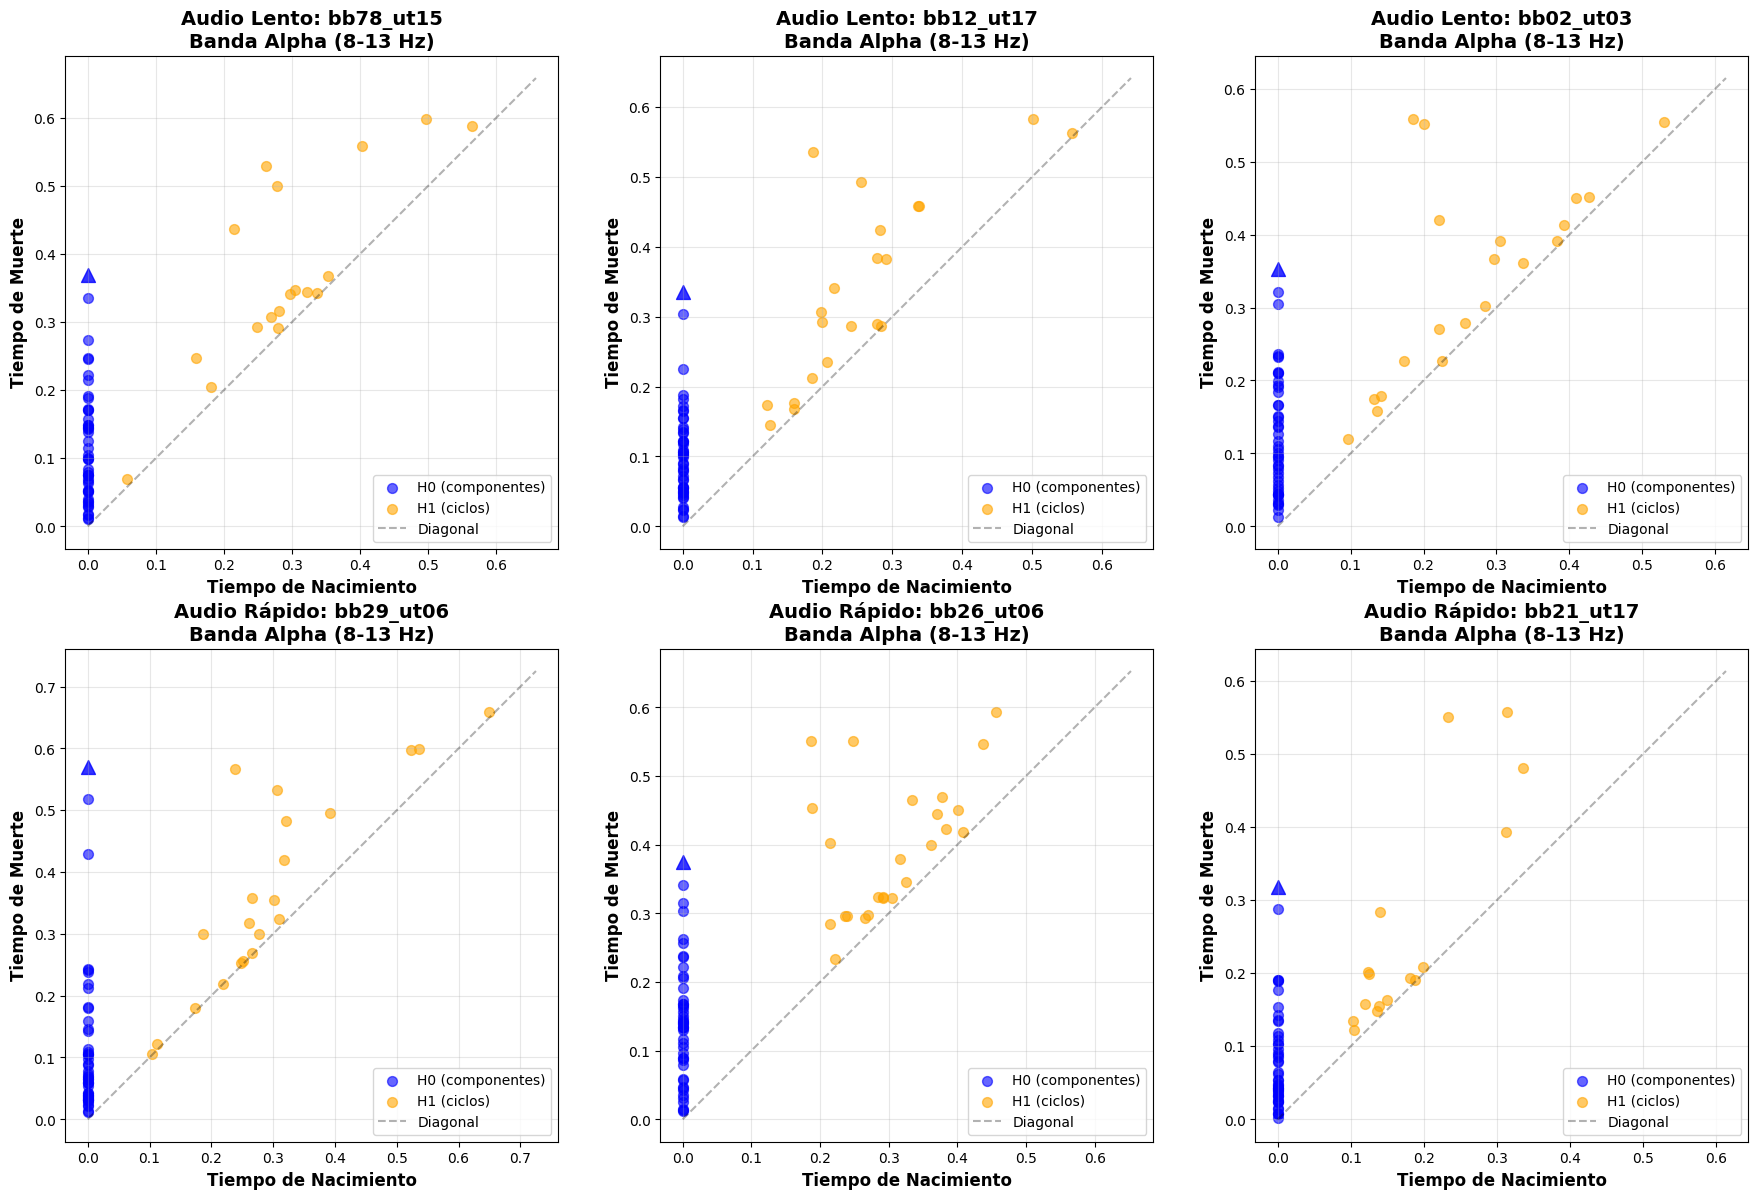


✓ Diagramas guardados en: resultados/diagramas_persistencia_comparacion.png


In [29]:

# Seleccionar archivos de ejemplo para visualizar diagramas de persistencia
import random
random.seed(42)

# Obtener listas de archivos procesados
archivos_slow = sorted(list((DIRECTORIO_GRAFOS / "slow").iterdir()))
archivos_fast = sorted(list((DIRECTORIO_GRAFOS / "fast").iterdir()))

# Seleccionar 3 ejemplos de cada condición
n_ejemplos = 3
ejemplos_slow = random.sample(archivos_slow, min(n_ejemplos, len(archivos_slow)))
ejemplos_fast = random.sample(archivos_fast, min(n_ejemplos, len(archivos_fast)))

# Función para cargar y calcular diagrama de un archivo
def cargar_y_calcular_diagrama(directorio_archivo, banda="alpha"):
    """Cargar matriz de distancia y calcular diagrama de persistencia."""
    archivo_dist = directorio_archivo / f"{banda}_distances.npy"
    
    if not archivo_dist.exists():
        return None
    
    matrices_distancia = np.load(archivo_dist)
    
    # Usar primera ventana de tiempo como ejemplo
    matriz_dist = matrices_distancia[0]
    
    # Calcular diagrama
    diagramas = calcular_diagrama_persistencia(
        matriz_dist, 
        DIMENSION_MAXIMA, 
        LONGITUD_ARISTA_MAXIMA
    )
    
    return diagramas

print(f"Visualizando diagramas de persistencia para banda alpha...")
print(f"Ejemplos seleccionados:")
print(f"  Audio lento: {[e.name for e in ejemplos_slow]}")
print(f"  Audio rápido: {[e.name for e in ejemplos_fast]}")

# Crear figura con subplots
fig, axes = plt.subplots(2, n_ejemplos, figsize=(6*n_ejemplos, 12))

# Plot ejemplos lentos
for i, archivo in enumerate(ejemplos_slow):
    diagramas = cargar_y_calcular_diagrama(archivo, "alpha")
    
    if diagramas is not None:
        ax = axes[0, i] if n_ejemplos > 1 else axes[0]
        graficar_diagrama_persistencia(
            diagramas, 
            titulo=f"Audio Lento: {archivo.name}\nBanda Alpha (8-13 Hz)",
            ax=ax
        )
    else:
        ax = axes[0, i] if n_ejemplos > 1 else axes[0]
        ax.text(0.5, 0.5, 'Datos no disponibles', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Audio Lento: {archivo.name}")

# Plot ejemplos rápidos
for i, archivo in enumerate(ejemplos_fast):
    diagramas = cargar_y_calcular_diagrama(archivo, "alpha")
    
    if diagramas is not None:
        ax = axes[1, i] if n_ejemplos > 1 else axes[1]
        graficar_diagrama_persistencia(
            diagramas,
            titulo=f"Audio Rápido: {archivo.name}\nBanda Alpha (8-13 Hz)",
            ax=ax
        )
    else:
        ax = axes[1, i] if n_ejemplos > 1 else axes[1]
        ax.text(0.5, 0.5, 'Datos no disponibles',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Audio Rápido: {archivo.name}")

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "diagramas_persistencia_comparacion.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Diagramas guardados en: {DIRECTORIO_RESULTADOS / 'diagramas_persistencia_comparacion.png'}")


### Comparación de Diagramas de Persistencia por Banda de Frecuencia

Ahora visualizamos cómo los diagramas de persistencia varían entre las diferentes bandas de frecuencia EEG. Cada banda captura diferentes tipos de actividad neural:

- **Delta (0.5-4 Hz)**: Sueño profundo, atención sostenida
- **Theta (4-8 Hz)**: Somnolencia, memoria, procesamiento emocional
- **Alpha (8-13 Hz)**: Relajación, estado de alerta tranquilo
- **Beta (13-30 Hz)**: Pensamiento activo, concentración, alerta
- **Gamma (30-50 Hz)**: Percepción, cognición de alto nivel


Comparando todas las bandas de frecuencia...
  Ejemplo lento: bb78_ut15
  Ejemplo rápido: bb29_ut06


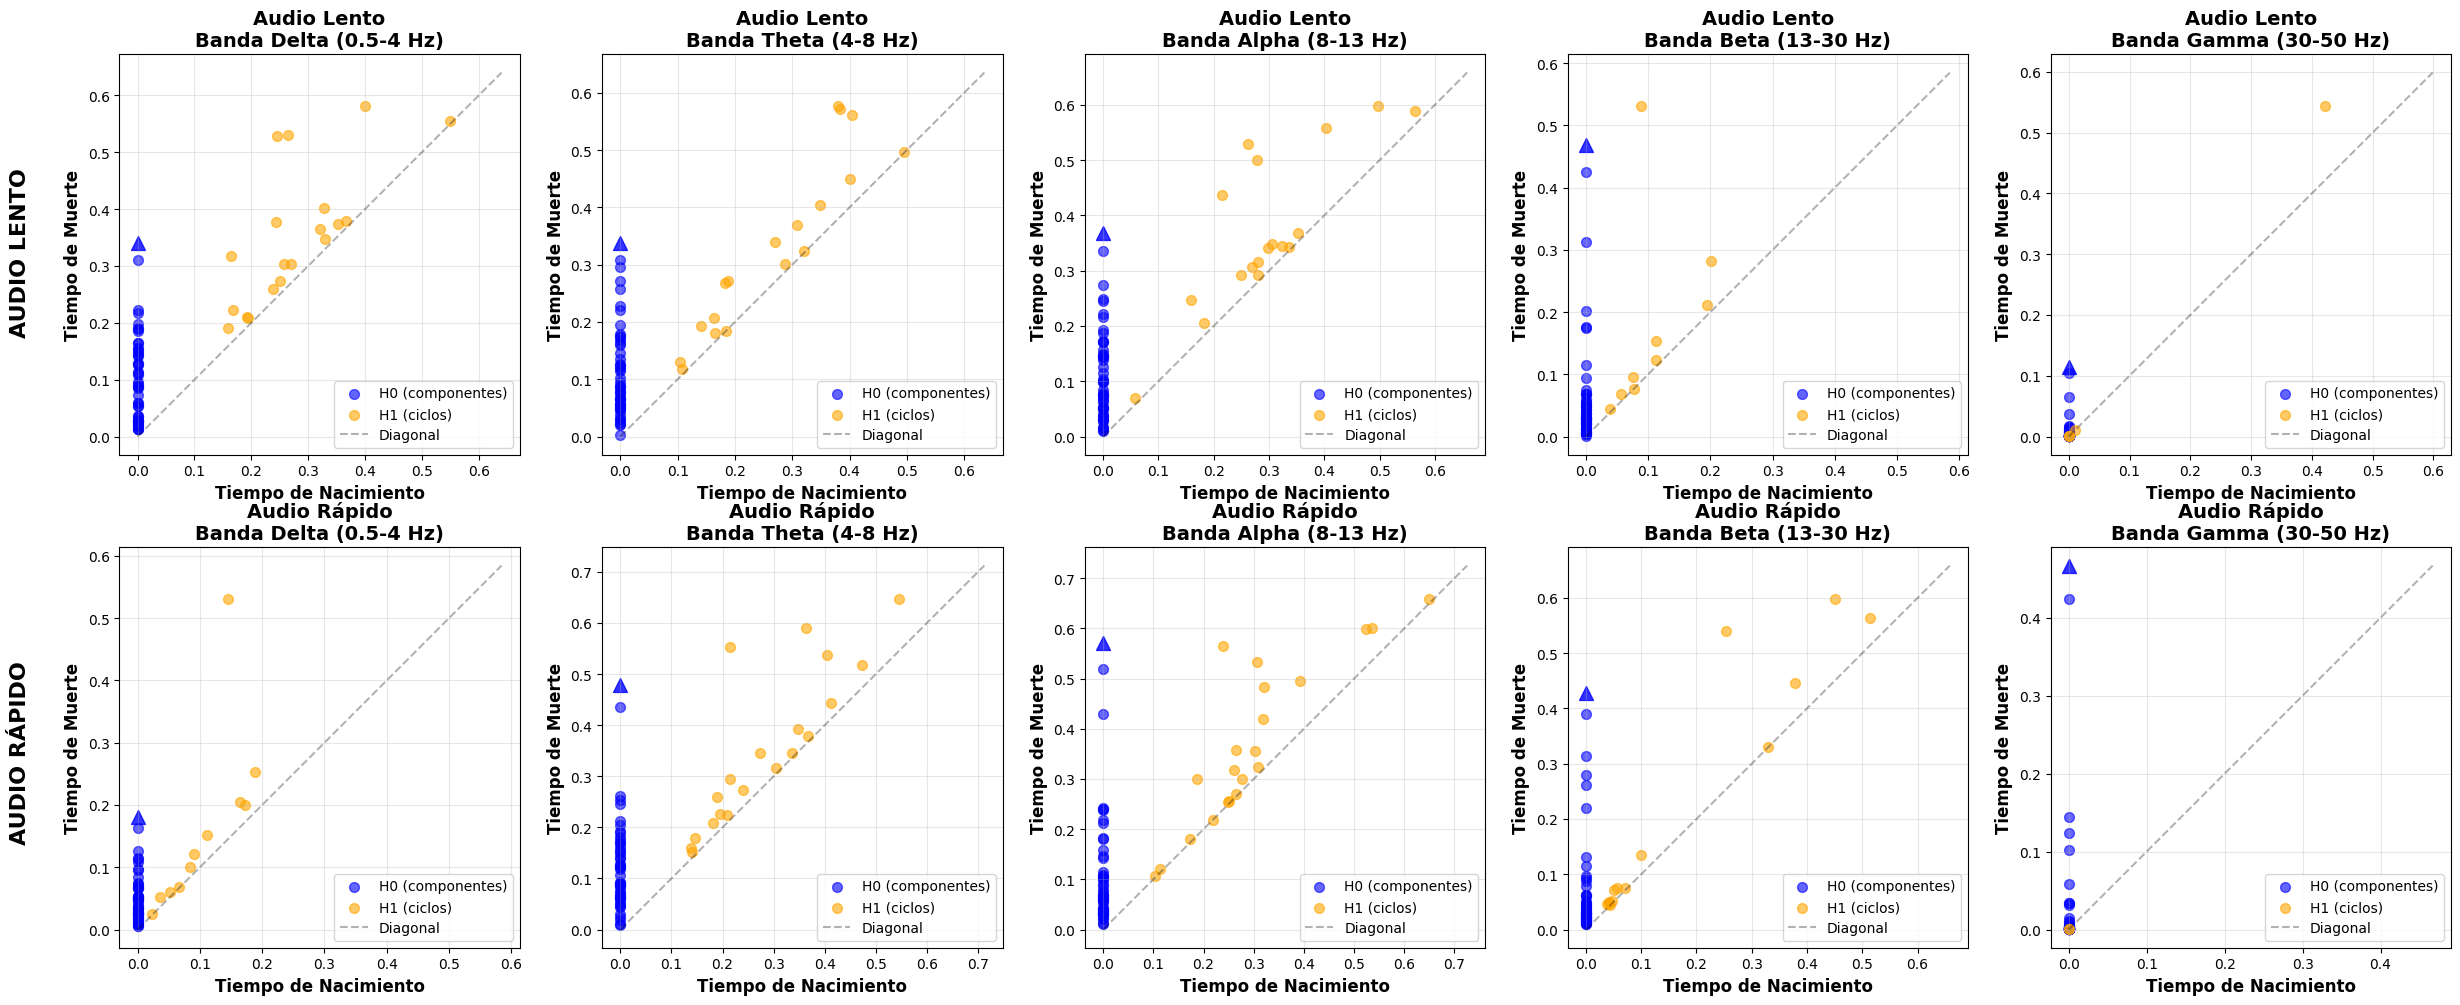


✓ Diagramas guardados en: resultados/diagramas_persistencia_todas_bandas.png

RESUMEN DE CARACTERÍSTICAS TOPOLÓGICAS

Condición: Lento
----------------------------------------------------------------------
  Delta : H0= 47 características (pers. media=0.099), H1= 19 características (pers. media=0.076)
  Theta : H0= 47 características (pers. media=0.112), H1= 18 características (pers. media=0.062)
  Alpha : H0= 47 características (pers. media=0.112), H1= 18 características (pers. media=0.076)
  Beta  : H0= 47 características (pers. media=0.060), H1=  9 características (pers. media=0.070)
  Gamma : H0= 47 características (pers. media=0.007), H1=  5 características (pers. media=0.025)

Condición: Rápido
----------------------------------------------------------------------
  Delta : H0= 47 características (pers. media=0.050), H1= 11 características (pers. media=0.058)
  Theta : H0= 47 características (pers. media=0.122), H1= 20 características (pers. media=0.067)
  Alpha : H0= 47 caracte

In [30]:

# Seleccionar un archivo de ejemplo de cada condición
archivo_ejemplo_slow = ejemplos_slow[0]
archivo_ejemplo_fast = ejemplos_fast[0]

# Crear figura con todas las bandas
bandas = ["delta", "theta", "alpha", "beta", "gamma"]
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

print(f"Comparando todas las bandas de frecuencia...")
print(f"  Ejemplo lento: {archivo_ejemplo_slow.name}")
print(f"  Ejemplo rápido: {archivo_ejemplo_fast.name}")

# Fila 1: Audio lento
for i, banda in enumerate(bandas):
    diagramas = cargar_y_calcular_diagrama(archivo_ejemplo_slow, banda)
    
    ax = axes[0, i]
    if diagramas is not None:
        graficar_diagrama_persistencia(
            diagramas,
            titulo=f"Audio Lento\nBanda {banda.capitalize()} ({FREQ_BANDS[banda][0]}-{FREQ_BANDS[banda][1]} Hz)",
            ax=ax
        )
    else:
        ax.text(0.5, 0.5, 'Datos no disponibles',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Audio Lento - {banda.capitalize()}")

# Fila 2: Audio rápido
for i, banda in enumerate(bandas):
    diagramas = cargar_y_calcular_diagrama(archivo_ejemplo_fast, banda)
    
    ax = axes[1, i]
    if diagramas is not None:
        graficar_diagrama_persistencia(
            diagramas,
            titulo=f"Audio Rápido\nBanda {banda.capitalize()} ({FREQ_BANDS[banda][0]}-{FREQ_BANDS[banda][1]} Hz)",
            ax=ax
        )
    else:
        ax.text(0.5, 0.5, 'Datos no disponibles',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Audio Rápido - {banda.capitalize()}")

# Añadir etiquetas de fila
fig.text(0.02, 0.75, 'AUDIO LENTO', rotation=90, fontsize=16, fontweight='bold', 
         va='center', ha='center')
fig.text(0.02, 0.25, 'AUDIO RÁPIDO', rotation=90, fontsize=16, fontweight='bold',
         va='center', ha='center')

plt.tight_layout(rect=[0.03, 0, 1, 1])
plt.savefig(DIRECTORIO_RESULTADOS / "diagramas_persistencia_todas_bandas.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Diagramas guardados en: {DIRECTORIO_RESULTADOS / 'diagramas_persistencia_todas_bandas.png'}")

# Imprimir resumen estadístico
print("\n" + "="*70)
print("RESUMEN DE CARACTERÍSTICAS TOPOLÓGICAS")
print("="*70)

for condicion, archivos in [("Lento", [archivo_ejemplo_slow]), ("Rápido", [archivo_ejemplo_fast])]:
    print(f"\nCondición: {condicion}")
    print("-"*70)
    
    for banda in bandas:
        diagramas = cargar_y_calcular_diagrama(archivos[0], banda)
        
        if diagramas is not None:
            h0_count = len(diagramas[0])
            h1_count = len(diagramas[1])
            
            # Calcular persistencia promedio
            h0_finite = diagramas[0][np.isfinite(diagramas[0]).all(axis=1)]
            h1_finite = diagramas[1][np.isfinite(diagramas[1]).all(axis=1)]
            
            h0_pers = np.mean(h0_finite[:, 1] - h0_finite[:, 0]) if len(h0_finite) > 0 else 0
            h1_pers = np.mean(h1_finite[:, 1] - h1_finite[:, 0]) if len(h1_finite) > 0 else 0
            
            print(f"  {banda.capitalize():6s}: H0={h0_count:3d} características (pers. media={h0_pers:.3f}), "
                  f"H1={h1_count:3d} características (pers. media={h1_pers:.3f})")


#### Análisis de Distribución de Sujetos



Muestras por sujeto:
  Media: 31.5
  Mediana: 32.0
  Mínimo: 7
  Máximo: 46

Distribución de etiquetas por sujeto:
           total   n_rapido  prop_rapido    n_lento
count  45.000000  45.000000    45.000000  45.000000
mean   31.466667  15.688889     0.503681  15.777778
std    10.055754   5.062438     0.059387   5.384696
min     7.000000   5.000000     0.333333   2.000000
25%    23.000000  12.000000     0.475000  11.000000
50%    32.000000  17.000000     0.500000  17.000000
75%    40.000000  20.000000     0.538462  20.000000
max    46.000000  23.000000     0.714286  23.000000

Sujetos con ambas condiciones: 45 / 45


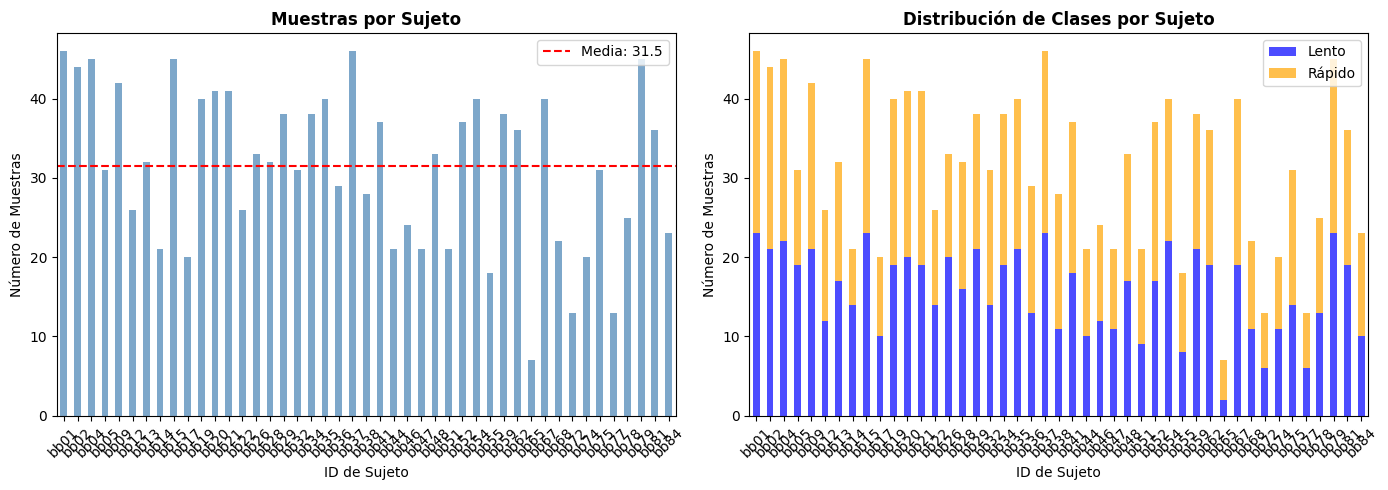

In [31]:

df_sujetos = pd.DataFrame({
    "sujeto": sujetos,
    "etiqueta": y,
    "nombre_etiqueta": ["lento" if e == 0 else "rapido" for e in y]
})

conteo_sujetos = df_sujetos.groupby("sujeto").size()
print(f"\nMuestras por sujeto:")
print(f"  Media: {conteo_sujetos.mean():.1f}")
print(f"  Mediana: {conteo_sujetos.median():.1f}")
print(f"  Mínimo: {conteo_sujetos.min()}")
print(f"  Máximo: {conteo_sujetos.max()}")

# Distribución de etiquetas por sujeto
etiquetas_sujeto = df_sujetos.groupby("sujeto")["etiqueta"].agg(["count", "sum", "mean"])
etiquetas_sujeto.columns = ["total", "n_rapido", "prop_rapido"]
etiquetas_sujeto["n_lento"] = etiquetas_sujeto["total"] - etiquetas_sujeto["n_rapido"]

print(f"\nDistribución de etiquetas por sujeto:")
print(etiquetas_sujeto.describe())

sujetos_mixtos = etiquetas_sujeto[(etiquetas_sujeto["n_lento"] > 0) & (etiquetas_sujeto["n_rapido"] > 0)]
print(f"\nSujetos con ambas condiciones: {len(sujetos_mixtos)} / {len(etiquetas_sujeto)}")

# Visualizar
fig, ejes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Muestras por sujeto
ax1 = ejes[0]
conteo_sujetos.plot(kind="bar", ax=ax1, color="steelblue", alpha=0.7)
ax1.set_xlabel("ID de Sujeto")
ax1.set_ylabel("Número de Muestras")
ax1.set_title("Muestras por Sujeto", fontweight="bold")
ax1.axhline(conteo_sujetos.mean(), color="red", linestyle="--", label=f"Media: {conteo_sujetos.mean():.1f}")
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución de etiquetas
ax2 = ejes[1]
etiquetas_sujeto[["n_lento", "n_rapido"]].plot(kind="bar", stacked=True, ax=ax2, color=["blue", "orange"], alpha=0.7)
ax2.set_xlabel("ID de Sujeto")
ax2.set_ylabel("Número de Muestras")
ax2.set_title("Distribución de Clases por Sujeto", fontweight="bold")
ax2.legend(["Lento", "Rápido"])
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "distribucion_sujetos.png", dpi=150)
plt.show()

## Cross Validation


Por qué la CV a nivel de sujeto es crítica:

1. Múltiples grabaciones por sujeto comparten patrones específicos del sujeto
2. Si el mismo sujeto aparece en entrenamiento y prueba, el modelo aprende identidad del sujeto
3. Esto causa fuga de datos y precisión inflada
4. La CV a nivel de sujeto asegura generalización a NUEVOS sujetos

Estrategia: GroupKFold (n_particiones={N_PARTICIONES})

- Grupos = sujetos
- Cada fold: ~{100 // N_PARTICIONES}% de sujetos en conjunto de prueba
- Ningún sujeto aparece en entrenamiento y prueba simultáneamente
- Más robusto que Leave-One-Subject-Out (conjuntos de prueba más grandes)


In [32]:


# Configurar CV
gkf = GroupKFold(n_splits=N_PARTICIONES)

# Verificar particiones de CV
print("Verificando particiones de CV...")
for fold, (idx_entrenamiento, idx_prueba) in enumerate(gkf.split(X, y, groups=sujetos)):
    sujetos_entrenamiento = set(sujetos[idx_entrenamiento])
    sujetos_prueba = set(sujetos[idx_prueba])
    solapamiento = sujetos_entrenamiento.intersection(sujetos_prueba)
    
    print(f"  Fold {fold + 1}:")
    print(f"    Entrenamiento: {len(idx_entrenamiento)} muestras, {len(sujetos_entrenamiento)} sujetos")
    print(f"    Prueba: {len(idx_prueba)} muestras, {len(sujetos_prueba)} sujetos")
    print(f"    Solapamiento de sujetos: {len(solapamiento)} (debería ser 0)")

Verificando particiones de CV...
  Fold 1:
    Entrenamiento: 1127 muestras, 36 sujetos
    Prueba: 289 muestras, 9 sujetos
    Solapamiento de sujetos: 0 (debería ser 0)
  Fold 2:
    Entrenamiento: 1129 muestras, 36 sujetos
    Prueba: 287 muestras, 9 sujetos
    Solapamiento de sujetos: 0 (debería ser 0)
  Fold 3:
    Entrenamiento: 1134 muestras, 36 sujetos
    Prueba: 282 muestras, 9 sujetos
    Solapamiento de sujetos: 0 (debería ser 0)
  Fold 4:
    Entrenamiento: 1134 muestras, 36 sujetos
    Prueba: 282 muestras, 9 sujetos
    Solapamiento de sujetos: 0 (debería ser 0)
  Fold 5:
    Entrenamiento: 1140 muestras, 36 sujetos
    Prueba: 276 muestras, 9 sujetos
    Solapamiento de sujetos: 0 (debería ser 0)


## Entrenamiento y Evaluación del Modelo


In [33]:
# Documentación y Verificación de Cross-Validation Setup

print("\n" + "=" * 70)
print("DOCUMENTACIÓN: CONFIGURACIÓN DE CROSS-VALIDATION")
print("=" * 70)

print("\n1. ESTRATEGIA DE VALIDACIÓN CRUZADA")
print("-" * 70)
print(f"  Método: GroupKFold")
print(f"  Número de folds: {N_PARTICIONES}")
print(f"  Semilla aleatoria: {SEMILLA_ALEATORIA}")
print(f"\n  ¿Por qué GroupKFold?")
print(f"    - Previene data leakage entre sujetos")
print(f"    - Cada sujeto aparece completo en train O en test, nunca en ambos")
print(f"    - Crítico para datos EEG donde múltiples muestras vienen del mismo sujeto")

print("\n2. DATOS PARA VALIDACIÓN CRUZADA")
print("-" * 70)
print(f"  Total de muestras: {len(y)}")
print(f"  Total de sujetos únicos: {len(np.unique(sujetos))}")
print(f"  Muestras por clase:")
print(f"    - Clase 0 (Lento): {np.sum(y == 0)} ({np.sum(y == 0) / len(y):.1%})")
print(f"    - Clase 1 (Rápido): {np.sum(y == 1)} ({np.sum(y == 1) / len(y):.1%})")
print(f"  Número de features: {X.shape[1]}")

print("\n3. VERIFICACIÓN DE SEPARACIÓN DE SUJETOS EN CADA FOLD")
print("-" * 70)

fold_info = []
for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=sujetos), 1):
    train_sujetos = set(sujetos[train_idx])
    test_sujetos = set(sujetos[test_idx])
    overlap = train_sujetos.intersection(test_sujetos)
    
    fold_info.append({
        'fold': fold_idx,
        'train_subjects': len(train_sujetos),
        'test_subjects': len(test_sujetos),
        'train_samples': len(train_idx),
        'test_samples': len(test_idx),
        'overlap': len(overlap),
        'train_class_balance': np.sum(y[train_idx] == 1) / len(train_idx),
        'test_class_balance': np.sum(y[test_idx] == 1) / len(test_idx)
    })
    
    print(f"\n  Fold {fold_idx}:")
    print(f"    Train: {len(train_sujetos)} sujetos, {len(train_idx)} muestras")
    print(f"    Test:  {len(test_sujetos)} sujetos, {len(test_idx)} muestras")
    print(f"    Balance clase 1 - Train: {fold_info[-1]['train_class_balance']:.1%}, Test: {fold_info[-1]['test_class_balance']:.1%}")
    print(f"    Overlap sujetos: {len(overlap)} {'✓ CORRECTO' if len(overlap) == 0 else '❌ ERROR'}")

# Verificar que no hay overlap en ningún fold
total_overlap = sum([info['overlap'] for info in fold_info])
print(f"\n  {'✓' if total_overlap == 0 else '❌'} Verificación: {total_overlap} overlaps totales encontrados")
print(f"  {'✓' if total_overlap == 0 else '❌'} GroupKFold está funcionando {'CORRECTAMENTE' if total_overlap == 0 else 'INCORRECTAMENTE'}")

print("\n4. RESUMEN DE DISTRIBUCIÓN POR FOLD")
print("-" * 70)

fold_df = pd.DataFrame(fold_info)
print(fold_df.to_string(index=False))

print("\n5. MÉTRICAS DE VALIDACIÓN UTILIZADAS")
print("-" * 70)
print("  - Accuracy (precisión): Proporción de predicciones correctas")
print("  - F1 Score (weighted): Media armónica de precisión y recall, ponderada por clase")
print("  - ROC AUC: Área bajo la curva ROC (capacidad de discriminación)")
print("  - Confusion Matrix: Matriz de confusión de predicciones")

print("\n6. FUNCIONES DE CROSS-VALIDATION UTILIZADAS")
print("-" * 70)
print("  cross_val_score():")
print("    - Retorna scores de cada fold")
print("    - Usado para: calcular precisión media y desviación estándar")
print("    - groups=sujetos asegura separación de sujetos")
print()
print("  cross_val_predict():")
print("    - Retorna predicciones out-of-fold para cada muestra")
print("    - Usado para: matriz de confusión, F1 score, classification report")
print("    - method='predict_proba' retorna probabilidades para ROC AUC")
print("    - groups=sujetos asegura separación de sujetos")

print("\n" + "=" * 70)
print("CONFIGURACIÓN VERIFICADA Y DOCUMENTADA")
print("=" * 70)


DOCUMENTACIÓN: CONFIGURACIÓN DE CROSS-VALIDATION

1. ESTRATEGIA DE VALIDACIÓN CRUZADA
----------------------------------------------------------------------
  Método: GroupKFold
  Número de folds: 5
  Semilla aleatoria: 42

  ¿Por qué GroupKFold?
    - Previene data leakage entre sujetos
    - Cada sujeto aparece completo en train O en test, nunca en ambos
    - Crítico para datos EEG donde múltiples muestras vienen del mismo sujeto

2. DATOS PARA VALIDACIÓN CRUZADA
----------------------------------------------------------------------
  Total de muestras: 1416
  Total de sujetos únicos: 45
  Muestras por clase:
    - Clase 0 (Lento): 710 (50.1%)
    - Clase 1 (Rápido): 706 (49.9%)
  Número de features: 220

3. VERIFICACIÓN DE SEPARACIÓN DE SUJETOS EN CADA FOLD
----------------------------------------------------------------------

  Fold 1:
    Train: 36 sujetos, 1127 muestras
    Test:  9 sujetos, 289 muestras
    Balance clase 1 - Train: 49.7%, Test: 50.5%
    Overlap sujetos: 0 ✓ 

In [34]:
# Grid Search para Optimización de Hiperparámetros
print("\n" + "=" * 70)
print("GRID SEARCH: Optimización de Hiperparámetros")
print("=" * 70)

from sklearn.model_selection import GridSearchCV

# Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [5, 10, 15, None],           # Profundidad máxima (None = sin límite)
    'min_samples_split': [2, 5, 10],          # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Mínimo de muestras en hoja
    'max_features': ['sqrt', 'log2']          # Número de features a considerar
}

print(f"\nEspacio de búsqueda:")
print(f"  n_estimators: {param_grid['n_estimators']}")
print(f"  max_depth: {param_grid['max_depth']}")
print(f"  min_samples_split: {param_grid['min_samples_split']}")
print(f"  min_samples_leaf: {param_grid['min_samples_leaf']}")
print(f"  max_features: {param_grid['max_features']}")
print(f"\nTotal de combinaciones: {3 * 4 * 3 * 3 * 2} = 216")

# Modelo base para grid search
modelo_base = RandomForestClassifier(
    random_state=SEMILLA_ALEATORIA,
    n_jobs=-1
)

# GridSearchCV con GroupKFold
print(f"\nEjecutando GridSearchCV con GroupKFold (k={N_PARTICIONES})...")
print("Esto puede tomar varios minutos...")

grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=gkf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Ejecutar grid search
grid_search.fit(X, y, groups=sujetos)

print("\n" + "=" * 70)
print("RESULTADOS DE GRID SEARCH")
print("=" * 70)

print(f"\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor precisión en validación cruzada: {grid_search.best_score_:.4f} ({grid_search.best_score_:.1%})")

# Comparar con modelo base (hiperparámetros originales)
modelo_original = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=SEMILLA_ALEATORIA,
    n_jobs=-1
)
score_original = cross_val_score(modelo_original, X, y, groups=sujetos, cv=gkf, scoring='accuracy').mean()

mejora = (grid_search.best_score_ - score_original) * 100
print(f"\nComparación con hiperparámetros originales:")
print(f"  Modelo original: {score_original:.4f} ({score_original:.1%})")
print(f"  Modelo optimizado: {grid_search.best_score_:.4f} ({grid_search.best_score_:.1%})")
print(f"  Mejora: {mejora:+.2f} puntos porcentuales")

# Top 5 mejores combinaciones
print(f"\n{'='*70}")
print("TOP 5 MEJORES COMBINACIONES")
print(f"{'='*70}")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values('rank_test_score')

for i, row in results_df_sorted.head(5).iterrows():
    print(f"\n#{int(row['rank_test_score'])} - Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   n_estimators={row['param_n_estimators']}, max_depth={row['param_max_depth']}, "
          f"min_samples_split={row['param_min_samples_split']}, "
          f"min_samples_leaf={row['param_min_samples_leaf']}, max_features={row['param_max_features']}")

# Guardar modelo optimizado
modelo_rf_optimizado = grid_search.best_estimator_

print(f"\n{'='*70}")
print("Modelo optimizado guardado en: modelo_rf_optimizado")
print(f"{'='*70}")


GRID SEARCH: Optimización de Hiperparámetros

Espacio de búsqueda:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

Total de combinaciones: 216 = 216

Ejecutando GridSearchCV con GroupKFold (k=5)...
Esto puede tomar varios minutos...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[

/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=15, max_features=sq

/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt

/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s


/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=15, max_features=sq

/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/tda/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ignaciagothe/Desktop/

[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, m


VISUALIZACIÓN DE RESULTADOS


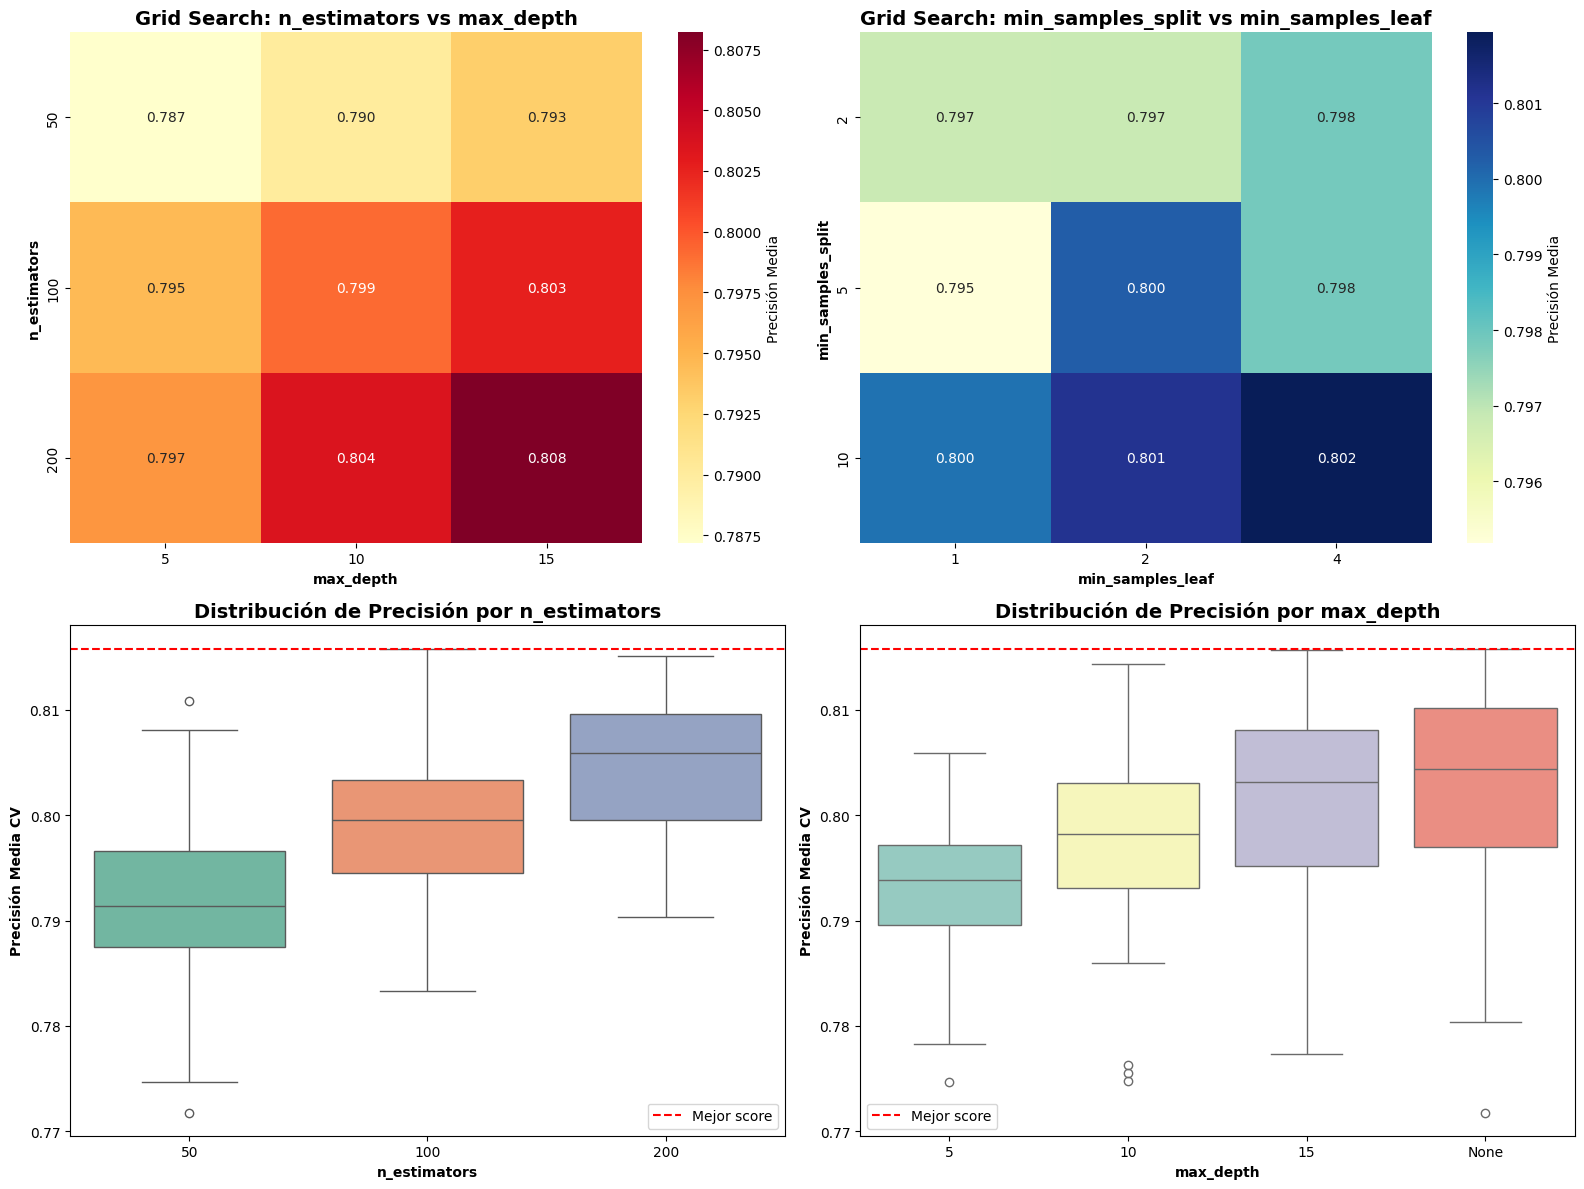

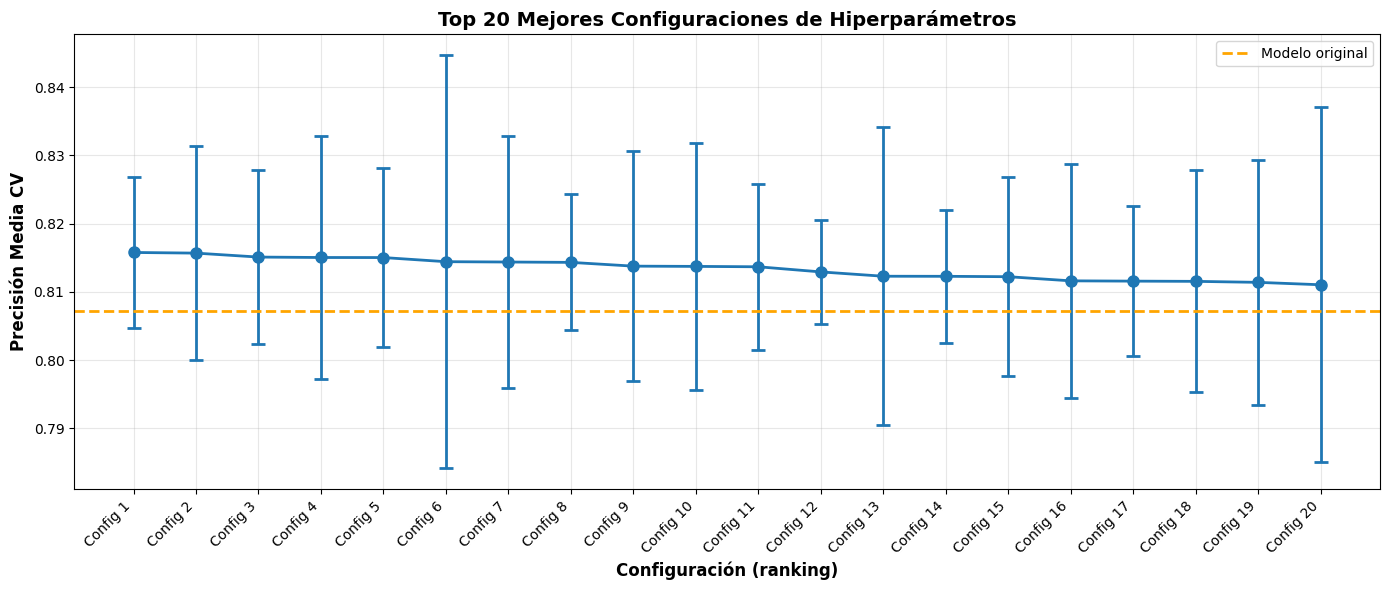


Visualizaciones guardadas en:
  - resultados/grid_search_visualizacion.png
  - resultados/grid_search_top20.png


In [35]:
# Visualización de Resultados de Grid Search

print("\n" + "=" * 70)
print("VISUALIZACIÓN DE RESULTADOS")
print("=" * 70)

# Preparar datos para visualización
results_df = pd.DataFrame(grid_search.cv_results_)

# 1. Heatmap: n_estimators vs max_depth (promediando otros parámetros)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: n_estimators vs max_depth
pivot_table_1 = results_df.pivot_table(
    values='mean_test_score',
    index='param_n_estimators',
    columns='param_max_depth',
    aggfunc='mean'
)

sns.heatmap(
    pivot_table_1,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    ax=axes[0, 0],
    cbar_kws={'label': 'Precisión Media'}
)
axes[0, 0].set_title('Grid Search: n_estimators vs max_depth', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('max_depth', fontweight='bold')
axes[0, 0].set_ylabel('n_estimators', fontweight='bold')

# Heatmap 2: min_samples_split vs min_samples_leaf
pivot_table_2 = results_df.pivot_table(
    values='mean_test_score',
    index='param_min_samples_split',
    columns='param_min_samples_leaf',
    aggfunc='mean'
)

sns.heatmap(
    pivot_table_2,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    ax=axes[0, 1],
    cbar_kws={'label': 'Precisión Media'}
)
axes[0, 1].set_title('Grid Search: min_samples_split vs min_samples_leaf', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('min_samples_leaf', fontweight='bold')
axes[0, 1].set_ylabel('min_samples_split', fontweight='bold')

# 3. Box plot: Distribución de scores por n_estimators
sns.boxplot(
    data=results_df,
    x='param_n_estimators',
    y='mean_test_score',
    ax=axes[1, 0],
    palette='Set2'
)
axes[1, 0].set_title('Distribución de Precisión por n_estimators', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('n_estimators', fontweight='bold')
axes[1, 0].set_ylabel('Precisión Media CV', fontweight='bold')
axes[1, 0].axhline(y=grid_search.best_score_, color='r', linestyle='--', label='Mejor score')
axes[1, 0].legend()

# 4. Box plot: Distribución de scores por max_depth
results_df_sorted_depth = results_df.copy()
results_df_sorted_depth['param_max_depth'] = results_df_sorted_depth['param_max_depth'].astype(str)

sns.boxplot(
    data=results_df_sorted_depth,
    x='param_max_depth',
    y='mean_test_score',
    ax=axes[1, 1],
    palette='Set3'
)
axes[1, 1].set_title('Distribución de Precisión por max_depth', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('max_depth', fontweight='bold')
axes[1, 1].set_ylabel('Precisión Media CV', fontweight='bold')
axes[1, 1].axhline(y=grid_search.best_score_, color='r', linestyle='--', label='Mejor score')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "grid_search_visualizacion.png", dpi=150, bbox_inches='tight')
plt.show()

# 5. Gráfico de líneas: Top 20 combinaciones
fig, ax = plt.subplots(figsize=(14, 6))

top_20 = results_df.nsmallest(20, 'rank_test_score')

x_labels = [f"Config {int(row['rank_test_score'])}" for _, row in top_20.iterrows()]
y_scores = top_20['mean_test_score'].values
y_std = top_20['std_test_score'].values

ax.errorbar(
    range(len(top_20)),
    y_scores,
    yerr=y_std,
    marker='o',
    linestyle='-',
    capsize=5,
    capthick=2,
    linewidth=2,
    markersize=8
)

ax.set_xticks(range(len(top_20)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('Configuración (ranking)', fontweight='bold', fontsize=12)
ax.set_ylabel('Precisión Media CV', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Mejores Configuraciones de Hiperparámetros', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=score_original, color='orange', linestyle='--', linewidth=2, label='Modelo original')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "grid_search_top20.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualizaciones guardadas en:")
print(f"  - {DIRECTORIO_RESULTADOS / 'grid_search_visualizacion.png'}")
print(f"  - {DIRECTORIO_RESULTADOS / 'grid_search_top20.png'}")


EVALUACIÓN DEL MODELO OPTIMIZADO

Hiperparámetros del modelo optimizado:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Evaluando modelo optimizado con GroupKFold CV (k=5)...

Resultados de Validación Cruzada:
  Precisión por fold: [0.79584775 0.82229965 0.82624113 0.81205674 0.82246377]
  Precisión media: 0.816 +/- 0.011
  Mín/Máx: 0.796 / 0.826

Obteniendo predicciones validadas cruzadamente...
  Puntaje F1 (ponderado): 0.816
  ROC AUC: 0.883

Reporte de Clasificación (Validación Cruzada):
              precision    recall  f1-score   support

       Lento       0.82      0.80      0.81       710
      Rápido       0.81      0.83      0.82       706

    accuracy                           0.82      1416
   macro avg       0.82      0.82      0.82      1416
weighted avg       0.82      0.82      0.82      1416



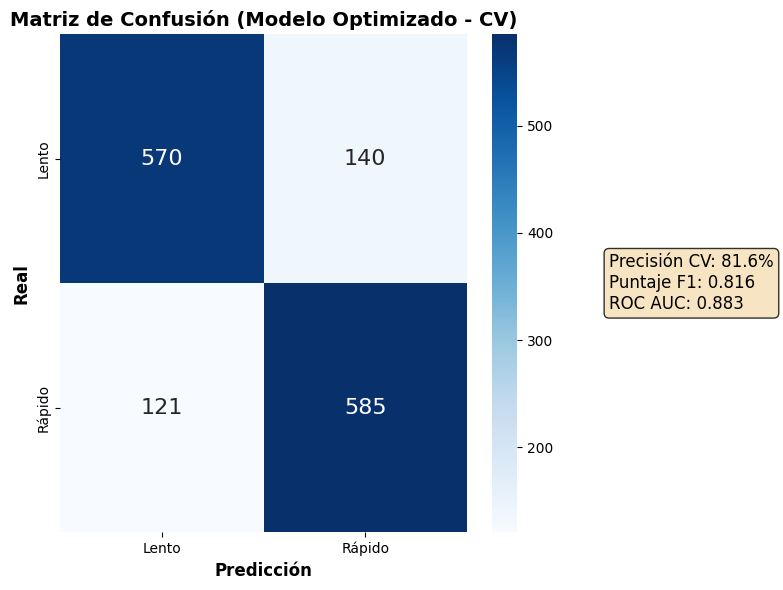


Nota: Esta matriz de confusión usa predicciones de VALIDACIÓN CRUZADA,
no predicciones del conjunto de entrenamiento. Esto da una estimación honesta del rendimiento.

Modelo optimizado listo para análisis posteriores.


In [36]:
# Usar el modelo optimizado del Grid Search
print("\n" + "=" * 70)
print("EVALUACIÓN DEL MODELO OPTIMIZADO")
print("=" * 70)

# El modelo optimizado ya está disponible de grid_search.best_estimator_
modelo_rf = modelo_rf_optimizado

print(f"\nHiperparámetros del modelo optimizado:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Puntajes de validación cruzada
print(f"\nEvaluando modelo optimizado con GroupKFold CV (k={N_PARTICIONES})...")
puntajes_cv = cross_val_score(
    modelo_rf, X, y, groups=sujetos, cv=gkf, scoring="accuracy"
)

print(f"\nResultados de Validación Cruzada:")
print(f"  Precisión por fold: {puntajes_cv}")
print(f"  Precisión media: {puntajes_cv.mean():.3f} +/- {puntajes_cv.std():.3f}")
print(f"  Mín/Máx: {puntajes_cv.min():.3f} / {puntajes_cv.max():.3f}")

# Obtener predicciones de CV para matriz de confusión (¡IMPORTANTE: no predicciones de entrenamiento!)
print("\nObteniendo predicciones validadas cruzadamente...")
y_pred_cv = cross_val_predict(modelo_rf, X, y, groups=sujetos, cv=gkf)

# Calcular métricas adicionales
f1_cv = f1_score(y, y_pred_cv, average="weighted")
print(f"  Puntaje F1 (ponderado): {f1_cv:.3f}")

# Intentar calcular AUC si es posible
try:
    # Obtener predicciones de probabilidad
    y_proba_cv = cross_val_predict(
        modelo_rf, X, y, groups=sujetos, cv=gkf, method="predict_proba"
    )
    auc_cv = roc_auc_score(y, y_proba_cv[:, 1])
    print(f"  ROC AUC: {auc_cv:.3f}")
except Exception as e:
    print(f"  ROC AUC: No se pudo calcular ({e})")
    auc_cv = None

# Reporte de clasificación (en predicciones de CV)
print("\nReporte de Clasificación (Validación Cruzada):")
print(classification_report(y, y_pred_cv, target_names=["Lento", "Rápido"]))


# ¡IMPORTANTE: Usando predicciones de CV, no predicciones de entrenamiento!
mc = confusion_matrix(y, y_pred_cv)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    mc,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Lento", "Rápido"],
    yticklabels=["Lento", "Rápido"],
    ax=ax,
    annot_kws={"size": 16}
)
ax.set_xlabel("Predicción", fontsize=12, fontweight="bold")
ax.set_ylabel("Real", fontsize=12, fontweight="bold")
ax.set_title("Matriz de Confusión (Modelo Optimizado - CV)", fontsize=14, fontweight="bold")

# Añadir texto con métricas
texto_metricas = f"Precisión CV: {puntajes_cv.mean():.1%}\nPuntaje F1: {f1_cv:.3f}"
if auc_cv:
    texto_metricas += f"\nROC AUC: {auc_cv:.3f}"
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax.text(1.35, 0.5, texto_metricas, transform=ax.transAxes, fontsize=12,
        verticalalignment="center", bbox=props)

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "matriz_confusion_cv_optimizado.png", dpi=150)
plt.show()

print("\nNota: Esta matriz de confusión usa predicciones de VALIDACIÓN CRUZADA,")
print("no predicciones del conjunto de entrenamiento. Esto da una estimación honesta del rendimiento.")
print("\nModelo optimizado listo para análisis posteriores.")

### Grafico importancia de las features


  gamma_h1_entropia_persistencia_std: 0.1038
  gamma_h0_entropia_persistencia_std: 0.0327
  gamma_h0_media_persistencia_std: 0.0241
  gamma_h0_media_muerte_std: 0.0236
  gamma_h0_total_persistencia_std: 0.0228
  gamma_h1_media_muerte_std: 0.0203
  gamma_h1_media_nacimiento_std: 0.0167
  alpha_h1_total_persistencia_std: 0.0139
  gamma_h1_entropia_persistencia_media: 0.0126
  gamma_h1_std_muerte_std: 0.0112
  delta_h1_media_muerte_std: 0.0111
  delta_h1_total_persistencia_std: 0.0103
  beta_h1_total_persistencia_std: 0.0096
  delta_h1_media_persistencia_std: 0.0094
  theta_h1_std_muerte_std: 0.0083


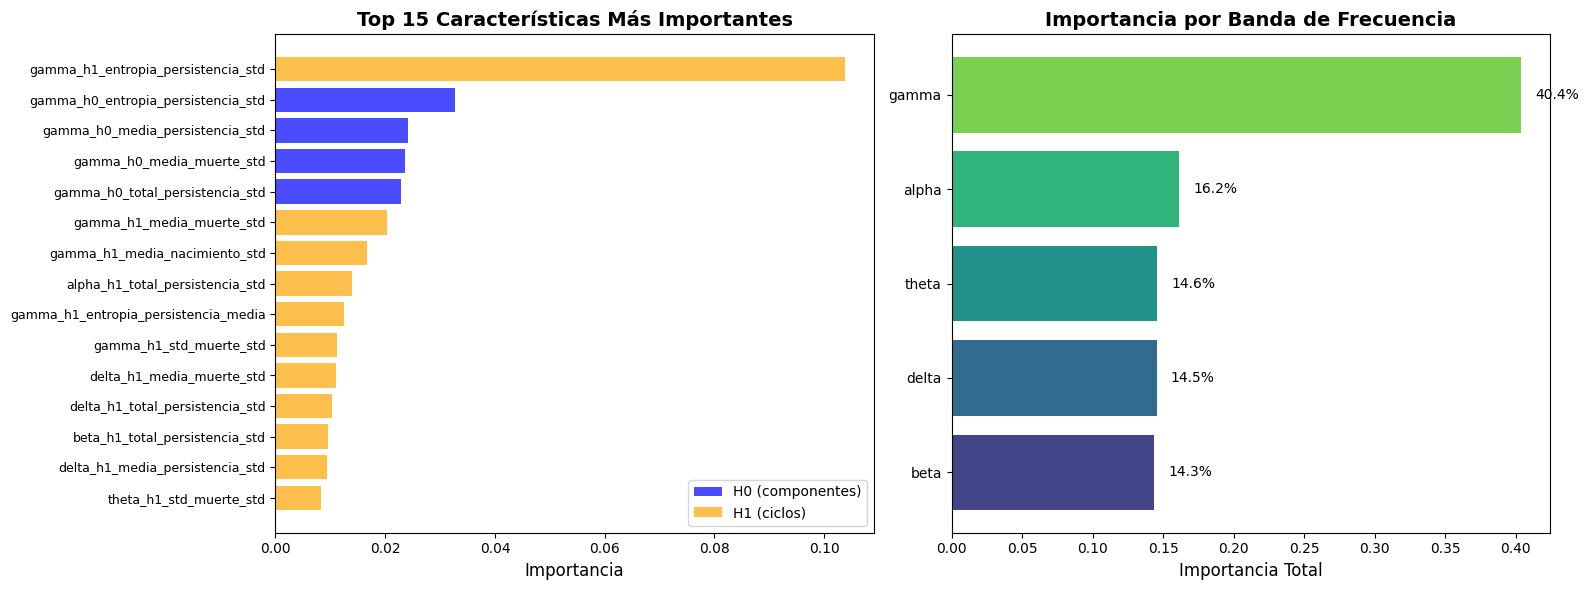


Resumen de Importancia por Banda:
          sum    mean  porcentaje
banda                            
gamma  0.4039  0.0092     40.3933
alpha  0.1615  0.0037     16.1535
theta  0.1458  0.0033     14.5795
delta  0.1453  0.0033     14.5322
beta   0.1434  0.0033     14.3415

Resumen de Importancia por Dimensión:
             sum    mean  porcentaje
dimension                           
H0         0.378  0.0034     37.7969
H1         0.622  0.0057     62.2031


In [37]:
modelo_rf.fit(X, y)
importancia_caracteristicas = modelo_rf.feature_importances_

df_importancia = pd.DataFrame({
    "caracteristica": nombres_caracteristicas,
    "importancia": importancia_caracteristicas
}).sort_values("importancia", ascending=False)


df_importancia["banda"] = df_importancia["caracteristica"].apply(
    lambda x: x.split("_")[0] if "_" in x else "desconocido"
)
df_importancia["dimension"] = df_importancia["caracteristica"].apply(
    lambda x: "H0" if "_h0_" in x else "H1" if "_h1_" in x else "desconocido"
)


for i, fila in df_importancia.head(15).iterrows():
    print(f"  {fila['caracteristica']}: {fila['importancia']:.4f}")

fig, ejes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = ejes[0]
top_15 = df_importancia.head(15)
colores = ["blue" if "h0" in c else "orange" for c in top_15["caracteristica"]]
ax1.barh(range(15), top_15["importancia"].values, color=colores, alpha=0.7)
ax1.set_yticks(range(15))
ax1.set_yticklabels(top_15["caracteristica"].values, fontsize=9)
ax1.set_xlabel("Importancia", fontsize=12)
ax1.set_title("Top 15 Características Más Importantes", fontsize=14, fontweight="bold")
ax1.invert_yaxis()

elementos_leyenda = [Patch(facecolor="blue", alpha=0.7, label="H0 (componentes)"),
                     Patch(facecolor="orange", alpha=0.7, label="H1 (ciclos)")]
ax1.legend(handles=elementos_leyenda, loc="lower right")

# Gráfico 2: Importancia por banda de frecuencia
ax2 = ejes[1]
importancia_banda = df_importancia.groupby("banda")["importancia"].sum().sort_values(ascending=True)
colores_banda = plt.cm.viridis(np.linspace(0.2, 0.8, len(importancia_banda)))
ax2.barh(importancia_banda.index, importancia_banda.values, color=colores_banda)
ax2.set_xlabel("Importancia Total", fontsize=12)
ax2.set_title("Importancia por Banda de Frecuencia", fontsize=14, fontweight="bold")

# Añadir etiquetas de porcentaje
importancia_total = importancia_banda.sum()
for i, (banda, imp) in enumerate(importancia_banda.items()):
    ax2.text(imp + 0.01, i, f"{imp / importancia_total * 100:.1f}%", va="center", fontsize=10)

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "importancia_caracteristicas.png", dpi=150)
plt.show()

# Resumen por banda y dimensión
print("\nResumen de Importancia por Banda:")
resumen_banda = df_importancia.groupby("banda")["importancia"].agg(["sum", "mean"]).sort_values("sum", ascending=False)
resumen_banda["porcentaje"] = resumen_banda["sum"] / resumen_banda["sum"].sum() * 100
print(resumen_banda.round(4))

print("\nResumen de Importancia por Dimensión:")
resumen_dim = df_importancia.groupby("dimension")["importancia"].agg(["sum", "mean"])
resumen_dim["porcentaje"] = resumen_dim["sum"] / resumen_dim["sum"].sum() * 100
print(resumen_dim.round(4))

# estadistica


### Prueba de Permutación:


H0 (hipótesis nula): La precisión de clasificación se debe al azar

H1 (alternativa): Las características topológicas contienen información discriminativa

Método: Permutar etiquetas N veces, calcular precisión CV cada vez

Valor p: Proporción de precisiones permutadas >= precisión observada


In [38]:
def prueba_permutacion_cv(X, y, grupos, modelo, cv, n_permutaciones=1000, semilla=42):
    puntajes_obs = cross_val_score(modelo, X, y, groups=grupos, cv=cv, scoring="accuracy")
    media_obs = puntajes_obs.mean()

    rng = np.random.default_rng(semilla)
    distribucion_nula = []

    for _ in range(n_permutaciones):
        y_perm = y.copy()
        for g in np.unique(grupos):
            idx = np.where(grupos == g)[0]
            y_perm[idx] = rng.permutation(y_perm[idx])

        puntajes_perm = cross_val_score(modelo, X, y_perm, groups=grupos, cv=cv, scoring="accuracy")
        distribucion_nula.append(puntajes_perm.mean())

    distribucion_nula = np.array(distribucion_nula)

    valor_p = (np.sum(distribucion_nula >= media_obs) + 1) / (n_permutaciones + 1)
    z = (media_obs - distribucion_nula.mean()) / distribucion_nula.std(ddof=1)

    return media_obs, distribucion_nula, valor_p, z



# Ejecutar prueba de permutación
precision_observada, dist_nula, valor_p, tamano_efecto = prueba_permutacion_cv(
    X, y, sujetos, modelo_rf, gkf, 
    n_permutaciones=N_PERMUTACIONES, 
    semilla=SEMILLA_ALEATORIA
)

print(f"\nResultados de Prueba de Permutación:")
print(f"  Precisión CV observada: {precision_observada:.4f} ({precision_observada:.1%})")
print(f"  Media distribución nula: {dist_nula.mean():.4f} ({dist_nula.mean():.1%})")
print(f"  Std distribución nula: {dist_nula.std():.4f}")
print(f"  Valor p: {valor_p:.6f}")
print(f"  Tamaño del efecto (d de Cohen): {tamano_efecto:.2f}")

# Interpretar tamaño del efecto
if abs(tamano_efecto) < 0.2:
    interpretacion_efecto = "insignificante"
elif abs(tamano_efecto) < 0.5:
    interpretacion_efecto = "pequeño"
elif abs(tamano_efecto) < 0.8:
    interpretacion_efecto = "mediano"
else:
    interpretacion_efecto = "grande"
print(f"  Interpretación del efecto: {interpretacion_efecto}")

# Interpretar significancia
alfa = 0.05
if valor_p < 0.001:
    nivel_sig = "*** (p < 0.001)"
elif valor_p < 0.01:
    nivel_sig = "** (p < 0.01)"
elif valor_p < 0.05:
    nivel_sig = "* (p < 0.05)"
else:
    nivel_sig = "ns (p >= 0.05)"
print(f"  Significancia: {nivel_sig}")


Resultados de Prueba de Permutación:
  Precisión CV observada: 0.8158 (81.6%)
  Media distribución nula: 0.5004 (50.0%)
  Std distribución nula: 0.0141
  Valor p: 0.000999
  Tamaño del efecto (d de Cohen): 22.29
  Interpretación del efecto: grande
  Significancia: *** (p < 0.001)


In [39]:
print("\n" + "=" * 60)
print("Validación Estadística: Intervalo de Confianza Bootstrap")
print("=" * 60)

def bootstrap_puntaje_cv(X, y, grupos, modelo, cv, n_bootstrap=1000, semilla=42):
    """Intervalo de confianza bootstrap para precisión CV mediante remuestreo de sujetos."""
    np.random.seed(semilla)
    puntajes_bootstrap = []
    
    sujetos_unicos = np.unique(grupos)
    n_sujetos = len(sujetos_unicos)
    
    for i in tqdm(range(n_bootstrap), desc="Bootstrap"):
        # Remuestrear sujetos con reemplazo
        sujetos_boot = np.random.choice(sujetos_unicos, size=n_sujetos, replace=True)
        
        # Obtener índices para sujetos seleccionados
        indices_boot = []
        nuevos_grupos = []
        for j, sujeto in enumerate(sujetos_boot):
            indices_sujeto = np.where(grupos == sujeto)[0]
            indices_boot.extend(indices_sujeto)
            # Mantener ID de grupo original para evitar data leakage
            nuevos_grupos.extend([sujeto] * len(indices_sujeto))
        
        indices_boot = np.array(indices_boot)
        nuevos_grupos = np.array(nuevos_grupos)
        
        X_boot = X[indices_boot]
        y_boot = y[indices_boot]
        
        # Verificar que tenemos ambas clases y suficientes grupos
        if len(np.unique(y_boot)) < 2:
            continue
        if len(np.unique(nuevos_grupos)) < cv.n_splits:
            continue
        
        try:
            puntajes_boot = cross_val_score(
                modelo, X_boot, y_boot, groups=nuevos_grupos, cv=cv, scoring="accuracy"
            )
            puntajes_bootstrap.append(puntajes_boot.mean())
        except Exception:
            continue
    
    return np.array(puntajes_bootstrap)


# Ejecutar bootstrap
precisiones_bootstrap = bootstrap_puntaje_cv(
    X, y, sujetos, modelo_rf, gkf,
    n_bootstrap=N_BOOTSTRAP,
    semilla=SEMILLA_ALEATORIA
)

# Intervalo de confianza (método de percentiles)
ic_inferior = np.percentile(precisiones_bootstrap, 2.5)
ic_superior = np.percentile(precisiones_bootstrap, 97.5)
ancho_ic = ic_superior - ic_inferior

print(f"\nResultados Bootstrap ({len(precisiones_bootstrap)} iteraciones exitosas):")
print(f"  Precisión media: {precisiones_bootstrap.mean():.4f} ({precisiones_bootstrap.mean():.1%})")
print(f"  Std: {precisiones_bootstrap.std():.4f}")
print(f"  Mediana: {np.median(precisiones_bootstrap):.4f}")
print(f"\nIntervalo de Confianza 95%:")
print(f"  [{ic_inferior:.4f}, {ic_superior:.4f}]")
print(f"  [{ic_inferior:.1%}, {ic_superior:.1%}]")
print(f"  Ancho: {ancho_ic:.4f} ({ancho_ic:.1%})")

# Verificar si IC excluye el azar
if ic_inferior > 0.5:
    print(f"\n  ✓ El IC completo está sobre el azar (50%) - resultado robusto")
else:
    print(f"\n  ⚠ El IC incluye el nivel de azar (50%) - el resultado puede no ser robusto")


Validación Estadística: Intervalo de Confianza Bootstrap


Bootstrap: 100%|██████████| 1000/1000 [08:11<00:00,  2.03it/s]


Resultados Bootstrap (1000 iteraciones exitosas):
  Precisión media: 0.7790 (77.9%)
  Std: 0.0199
  Mediana: 0.7810

Intervalo de Confianza 95%:
  [0.7329, 0.8128]
  [73.3%, 81.3%]
  Ancho: 0.0799 (8.0%)

  ✓ El IC completo está sobre el azar (50%) - resultado robusto


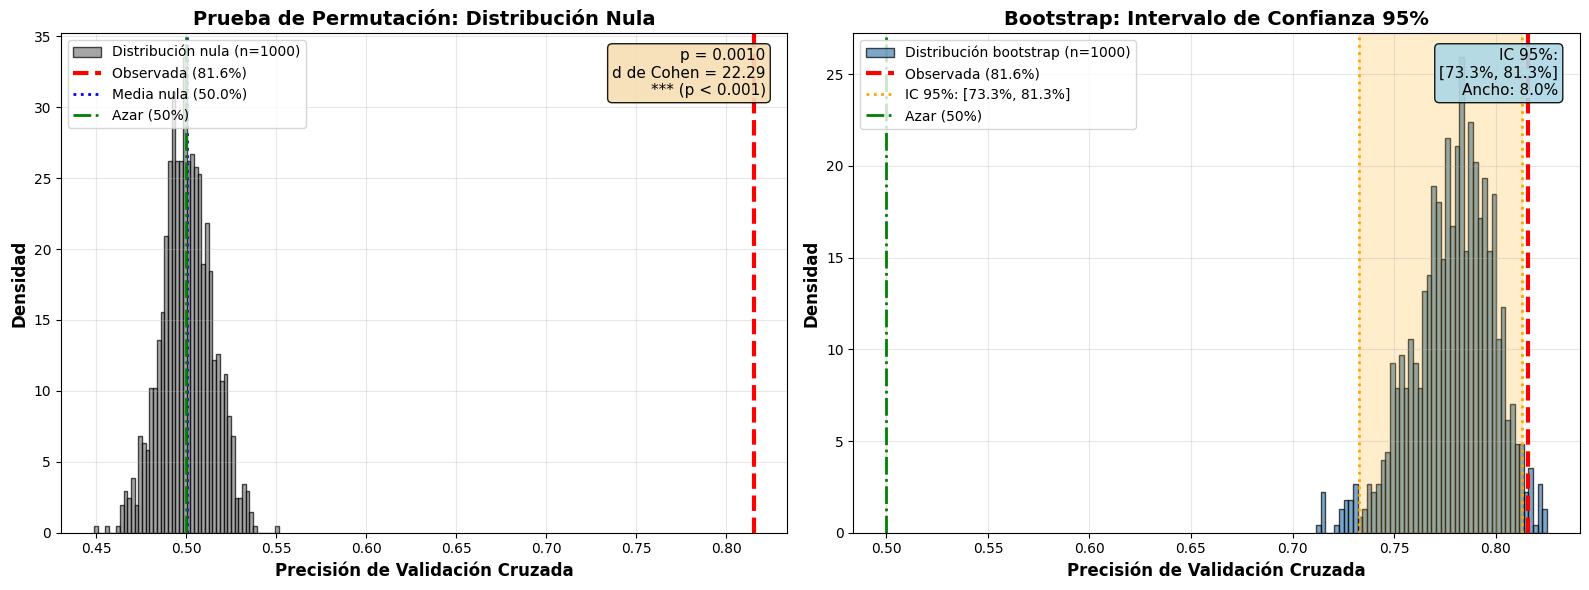

In [40]:
fig, ejes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Prueba de Permutación
ax1 = ejes[0]
ax1.hist(dist_nula, bins=50, alpha=0.7, color="gray", edgecolor="black", density=True,
         label=f"Distribución nula (n={N_PERMUTACIONES})")
ax1.axvline(precision_observada, color="red", linewidth=3, linestyle="--",
            label=f"Observada ({precision_observada:.1%})")
ax1.axvline(dist_nula.mean(), color="blue", linewidth=2, linestyle=":",
            label=f"Media nula ({dist_nula.mean():.1%})")
ax1.axvline(0.5, color="green", linewidth=2, linestyle="-.",
            label="Azar (50%)")

ax1.set_xlabel("Precisión de Validación Cruzada", fontsize=12, fontweight="bold")
ax1.set_ylabel("Densidad", fontsize=12, fontweight="bold")
ax1.set_title("Prueba de Permutación: Distribución Nula", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3)

# Añadir anotación de valor p
texto_p = f"p = {valor_p:.4f}\nd de Cohen = {tamano_efecto:.2f}\n{nivel_sig}"
props = dict(boxstyle="round", facecolor="wheat", alpha=0.9)
ax1.text(0.97, 0.97, texto_p, transform=ax1.transAxes, fontsize=11,
         verticalalignment="top", horizontalalignment="right", bbox=props)

# Gráfico 2: Distribución Bootstrap
ax2 = ejes[1]
ax2.hist(precisiones_bootstrap, bins=50, alpha=0.7, color="steelblue", edgecolor="black", density=True,
         label=f"Distribución bootstrap (n={len(precisiones_bootstrap)})")
ax2.axvline(precision_observada, color="red", linewidth=3, linestyle="--",
            label=f"Observada ({precision_observada:.1%})")
ax2.axvline(ic_inferior, color="orange", linewidth=2, linestyle=":",
            label=f"IC 95%: [{ic_inferior:.1%}, {ic_superior:.1%}]")
ax2.axvline(ic_superior, color="orange", linewidth=2, linestyle=":")
ax2.axvspan(ic_inferior, ic_superior, alpha=0.2, color="orange")
ax2.axvline(0.5, color="green", linewidth=2, linestyle="-.", label="Azar (50%)")

ax2.set_xlabel("Precisión de Validación Cruzada", fontsize=12, fontweight="bold")
ax2.set_ylabel("Densidad", fontsize=12, fontweight="bold")
ax2.set_title("Bootstrap: Intervalo de Confianza 95%", fontsize=14, fontweight="bold")
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(True, alpha=0.3)

# Añadir anotación de IC
texto_ic = f"IC 95%:\n[{ic_inferior:.1%}, {ic_superior:.1%}]\nAncho: {ancho_ic:.1%}"
props = dict(boxstyle="round", facecolor="lightblue", alpha=0.9)
ax2.text(0.97, 0.97, texto_ic, transform=ax2.transAxes, fontsize=11,
         verticalalignment="top", horizontalalignment="right", bbox=props)

plt.tight_layout()
plt.savefig(DIRECTORIO_RESULTADOS / "pruebas_estadisticas.png", dpi=150)
plt.show()

In [41]:
print("\n" + "=" * 70)
print("RESULTADOS FINALES Y CONCLUSIONES")
print("=" * 70)

# Tabla resumen
print("\n" + "-" * 70)
print("TABLA RESUMEN")
print("-" * 70)

resumen_resultados = {
    "Métrica": [
        "Tamaño del conjunto de datos",
        "Número de características",
        "Número de sujetos",
        "Balance de clases (Lento/Rápido)",
        "",
        "Precisión CV (GroupKFold-5)",
        "Puntaje F1 (ponderado)",
        "Línea base (azar)",
        "Mejora sobre línea base",
        "",
        "Valor p (prueba de permutación)",
        "Tamaño del efecto (d de Cohen)",
        "Límite inferior IC 95%",
        "Límite superior IC 95%",
        "¿IC sobre el azar?",
    ],
    "Valor": [
        f"{X.shape[0]} muestras",
        f"{X.shape[1]} características",
        f"{len(np.unique(sujetos))} sujetos",
        f"{np.sum(y == 0)} / {np.sum(y == 1)}",
        "",
        f"{puntajes_cv.mean():.1%} ± {puntajes_cv.std():.1%}",
        f"{f1_cv:.3f}",
        "50%",
        f"+{(puntajes_cv.mean() - 0.5) * 100:.1f} puntos porcentuales",
        "",
        f"{valor_p:.6f} {nivel_sig}",
        f"{tamano_efecto:.2f} ({interpretacion_efecto})",
        f"{ic_inferior:.1%}",
        f"{ic_superior:.1%}",
        "Sí" if ic_inferior > 0.5 else "No",
    ],
}

df_resultados = pd.DataFrame(resumen_resultados)
print(df_resultados.to_string(index=False))

# Bandas más importantes
print("\n" + "-" * 70)
print("BANDAS DE FRECUENCIA MÁS DISCRIMINATIVAS")
print("-" * 70)
print(resumen_banda.round(3).to_string())

# Interpretación
print("\n" + "-" * 70)
print("INTERPRETACIÓN")
print("-" * 70)

print(f"""
Pregunta de Investigación:
  ¿Podemos distinguir entre condiciones de audio lento y rápido en infantes
  basándonos en la topología de conectividad EEG?

Resultados:
  - Precisión validada cruzadamente: {puntajes_cv.mean():.1%} (azar = 50%)
  - Esto es {(puntajes_cv.mean() - 0.5) * 100:.1f} puntos porcentuales sobre el azar
  - Valor p = {valor_p:.6f} → {"estadísticamente significativo" if valor_p < 0.05 else "no estadísticamente significativo"}
  - Tamaño del efecto = {tamano_efecto:.2f} → significancia práctica {interpretacion_efecto}
  - IC 95% = [{ic_inferior:.1%}, {ic_superior:.1%}]
""")

# Nivel de evidencia
if puntajes_cv.mean() > 0.65 and valor_p < 0.05 and ic_inferior > 0.5:
    evidencia = "FUERTE"
    conclusion = """
Las características topológicas de los grafos de conectividad EEG distinguen exitosamente
entre condiciones de audio lento y rápido. Esto sugiere que:

1. El audio lento vs rápido induce patrones de conectividad cerebral mediblemente diferentes
2. Estas diferencias son robustas entre sujetos (no artefactos específicos del sujeto)
3. El Análisis de Datos Topológicos captura diferencias significativas en la señal neural

Las bandas de frecuencia más discriminativas proporcionan información sobre qué tipos de
oscilaciones neurales son más afectadas por la velocidad del audio."""

elif puntajes_cv.mean() > 0.55 and valor_p < 0.05:
    evidencia = "MODERADA"
    conclusion = """
Hay evidencia moderada de que las características topológicas pueden distinguir condiciones.
La precisión está sobre el azar y es estadísticamente significativa, pero el tamaño
del efecto es modesto. Esto sugiere:

1. Existen algunas diferencias en topología de conectividad entre condiciones
2. La señal puede ser débil o variable entre sujetos
3. Considerar: más sujetos, diferentes características, o enfoques alternativos"""

else:
    evidencia = "DÉBIL/NINGUNA"
    conclusion = """
Las características topológicas no distinguen confiablemente entre condiciones.
Posibles explicaciones:

1. La velocidad del audio puede no afectar significativamente la topología de conectividad EEG
2. El efecto existe pero es demasiado sutil para los métodos actuales
3. Se necesitan más sujetos o diferente preprocesamiento
4. Se podrían explorar enfoques TDA alternativos (ej., diferentes filtraciones)"""

print(f"Nivel de Evidencia: {evidencia}")
print(conclusion)

# Guardar resultados
diccionario_resultados = {
    "precision_cv_media": puntajes_cv.mean(),
    "precision_cv_std": puntajes_cv.std(),
    "puntaje_f1_cv": f1_cv,
    "valor_p": valor_p,
    "tamano_efecto": tamano_efecto,
    "ic_inferior": ic_inferior,
    "ic_superior": ic_superior,
    "n_muestras": X.shape[0],
    "n_caracteristicas": X.shape[1],
    "n_sujetos": len(np.unique(sujetos)),
    "nivel_evidencia": evidencia,
}

# Guardar como JSON
import json
with open(DIRECTORIO_RESULTADOS / "resumen_resultados.json", "w") as f:
    json.dump(diccionario_resultados, f, indent=2)

print(f"\nResultados guardados en {DIRECTORIO_RESULTADOS}/")
print("  - matriz_confusion_cv.png")
print("  - importancia_caracteristicas.png")
print("  - pruebas_estadisticas.png")
print("  - distribucion_sujetos.png")
print("  - diagrama_persistencia_ejemplo.png")
print("  - resumen_resultados.json")

print("\n" + "=" * 70)
print("ANÁLISIS COMPLETADO")
print("=" * 70)


RESULTADOS FINALES Y CONCLUSIONES

----------------------------------------------------------------------
TABLA RESUMEN
----------------------------------------------------------------------
                         Métrica                     Valor
    Tamaño del conjunto de datos             1416 muestras
       Número de características       220 características
               Número de sujetos                45 sujetos
Balance de clases (Lento/Rápido)                 710 / 706
                                                          
     Precisión CV (GroupKFold-5)              81.6% ± 1.1%
          Puntaje F1 (ponderado)                     0.816
               Línea base (azar)                       50%
         Mejora sobre línea base +31.6 puntos porcentuales
                                                          
 Valor p (prueba de permutación)  0.000999 *** (p < 0.001)
  Tamaño del efecto (d de Cohen)            22.29 (grande)
          Límite inferior IC 95%         